# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import dataset

In [5]:
data_train = pd.read_csv("/content/drive/MyDrive/data/data/train.csv",sep="|")
data_items = pd.read_csv("/content/drive/MyDrive/data/data/items.csv",sep="|")
data_new = pd.merge( data_train, data_items, how='left', on='pid' )

data_class = pd.read_csv("/content/drive/MyDrive/data/data/class.csv",sep="|")
data_class.set_index('lineID',inplace=True,drop=True)
data_realclass = pd.read_csv("/content/drive/MyDrive/data/data/realclass.csv",sep="|")
data_realclass.rename(columns={'revenue':'actual_revenue'},inplace=True)
data_realclass.set_index("lineID",inplace=True,drop=True)
test_data = data_class.join(data_realclass,on='lineID',how='inner')
test_data = pd.merge( test_data, data_items, how='left', on='pid' )

data_new.shape, test_data.shape

((2756003, 21), (1210767, 17))

In [6]:

data_new.head()

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,18,1COJ0FIK,50,ST,TAB,1,40,66.0,C,18.81
2,3,1,16382,0,1,14.77,0,1,0,16.06,...,41,22OI7,2X50,ML,STI,0,53,40.0,NaN,18.48
3,4,1,1145,1,1,6.59,0,0,1,6.55,...,52,18OZ00IS,60,G,GEL,0,40,25.0,NaN,9.31
4,5,1,3394,0,1,4.39,0,0,1,4.14,...,90,20OI0,25X2,ST,KOM,0,53,14.0,NaN,8.13


In [ ]:
# Change data type of category column into integer and skip missing values
def convert_to_int(x):
    try:
        return int(x)
    except:
        return np.nan

data_new['category'] = data_new['category'].apply(convert_to_int)
test_data['category'] = test_data['category'].apply(convert_to_int)

In [ ]:
def convert_content_column_into_numbers(item):
    try:
        return float(item)
    except:
        # extract numbers seperated by alphabet (using regex)
        import re
        item = re.findall(r'\d+\.?\d*', item)
        # multiply the numbers to get the final number
        final_number = 1
        for i in item:
            final_number = final_number*float(i)
        return final_number


# item = 'L  150'
# convert_content_column_into_numbers(item)

data_new['content'] = data_new['content'].apply(convert_content_column_into_numbers)
test_data['content'] = test_data['content'].apply(convert_content_column_into_numbers)

# Missing Values

In [ ]:

features_null_values=[features for features in data_new.columns if data_new[features].isnull().sum()>1]
for i in features_null_values:
    print(i, np.round(data_new[i].isnull().mean()*100,4), ' % missing values')

competitorPrice 3.6534  % missing values
pharmForm 7.0437  % missing values
category 3.171  % missing values
campaignIndex 83.0176  % missing values


In [ ]:
# Drop columns with more than 50% missing values
data_new.drop(columns=['campaignIndex'],inplace=True)
test_data.drop(columns=['campaignIndex'],inplace=True)

In [ ]:
# Drop insignifincant columns
data_new.drop(columns=['lineID'],inplace=True)


In [ ]:
data_new.head()

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,6570,0,2,14.60,1,0,0,16.89,0.00,255,2FOI,50.0,ML,TRO,0,40,193.0,18.25
1,1,14922,1,1,8.57,0,1,0,8.75,0.00,18,1COJ0FIK,50.0,ST,TAB,1,40,66.0,18.81
2,1,16382,0,1,14.77,0,1,0,16.06,0.00,41,22OI7,100.0,ML,STI,0,53,40.0,18.48
3,1,1145,1,1,6.59,0,0,1,6.55,6.55,52,18OZ00IS,60.0,G,GEL,0,40,25.0,9.31
4,1,3394,0,1,4.39,0,0,1,4.14,4.14,90,20OI0,50.0,ST,KOM,0,53,14.0,8.13


In [ ]:
data_new.columns

Index(['day', 'pid', 'adFlag', 'availability', 'competitorPrice', 'click',
       'basket', 'order', 'price', 'revenue', 'manufacturer', 'group',
       'content', 'unit', 'pharmForm', 'genericProduct', 'salesIndex',
       'category', 'rrp'],
      dtype='object')

## **Column Types**
#### **Categorical** :
#### 'PID', 'AdFlag', 'Availability', 'Click', 'Basket', 'Order', 'Manufacturer', 'Group', 'Content', 'Unit', 'PharmForm', 'GenericProduct', 'Category'
#### **Ratio** : 'Price', 'CompetitorPrice', 'Revenue', 'RRP'
#### **Ordinal**: 'SalesIndex'
#### **Interval**: 'Day'


In [ ]:
# Print catgorical columns and count of unique values in each column
cat_cols = ['group','unit','pharmForm','salesIndex']
cat_num_cols =  ['manufacturer','adFlag','availability', "genericProduct", 'category']
for col in cat_cols+cat_num_cols:
    print( "Column: ", col , "  | Count of Unique Values: ", data_new[col].nunique() , "\n ------------" )

Column:  group   | Count of Unique Values:  533 
 ------------
Column:  unit   | Count of Unique Values:  8 
 ------------
Column:  pharmForm   | Count of Unique Values:  278 
 ------------
Column:  salesIndex   | Count of Unique Values:  4 
 ------------
Column:  manufacturer   | Count of Unique Values:  1065 
 ------------
Column:  adFlag   | Count of Unique Values:  2 
 ------------
Column:  availability   | Count of Unique Values:  4 
 ------------
Column:  genericProduct   | Count of Unique Values:  2 
 ------------
Column:  category   | Count of Unique Values:  409 
 ------------


To group categorical columns with a high number of unique values (greater than 10) into 4 increasing groups, ensuring that the majority of the data is in the highest group:

**Approach**:
For each categorical column with more than 10 unique values, determine the frequency distribution of each unique category.
Group the categories into 4 bins based on their frequency, such that the highest group (Group 4) contains the categories with the most occurrences.
Use quartile-based binning or custom thresholds to distribute the values, ensuring that Group 4 holds the most common categories.

In [ ]:


data = data_new[['group', 'pharmForm', 'manufacturer', 'category']]

# Define a function to group high cardinality categorical columns into numeric bins
def group_categorical_numeric(column, n_groups=4):
    # Count frequency of each category
    freq = data[column].value_counts()

    # Create bins using quantile cuts, resulting in numeric labels (1 = lowest frequency, n_groups = highest frequency)
    labels = list(range(1, n_groups+1))  # Numeric labels for bins

    # Create bins based on frequency rank
    data[f'{column}_grouped'] = pd.qcut(freq.rank(method='first', ascending=True), q=n_groups, labels=labels)

    # Map the original column values to their respective numeric group
    data[f'{column}_grouped'] = data[column].map(freq).rank(method='first', ascending=True)
    data[f'{column}_grouped'] = pd.qcut(data[f'{column}_grouped'], q=n_groups, labels=labels)

    return data[f'{column}_grouped']

# Apply to columns with high unique values (greater than 10)
data['group_grouped'] = group_categorical_numeric('group')
data['pharmForm_grouped'] = group_categorical_numeric('pharmForm')
data['manufacturer_grouped'] = group_categorical_numeric('manufacturer')
data['category_grouped'] = group_categorical_numeric('category')


# Convert the decimal grouped columns to integers (nullable) while preserving NaN values
data['group_grouped'] = data['group_grouped'].astype('Int64')
data['pharmForm_grouped'] = data['pharmForm_grouped'].astype('Int64')
data['manufacturer_grouped'] = data['manufacturer_grouped'].astype('Int64')
data['category_grouped'] = data['category_grouped'].astype('Int64')

data.head()

,group,pharmForm,manufacturer,category,group_grouped,pharmForm_grouped,manufacturer_grouped,category_grouped
0,2FOI,TRO,255,193.0,4,2,2,2
1,1COJ0FIK,TAB,18,66.0,2,4,4,4
2,22OI7,STI,41,40.0,2,1,3,2
3,18OZ00IS,GEL,52,25.0,3,3,4,4
4,20OI0,KOM,90,14.0,2,1,3,1


In [ ]:

data_new['group_grouped'] = data['group_grouped']
data_new['pharmForm_grouped'] = data['pharmForm_grouped']
data_new['manufacturer_grouped'] = data['manufacturer_grouped']
data_new['category_grouped'] = data['category_grouped']
data_new.drop(columns=['group','pharmForm','manufacturer','category'],inplace=True)




In [ ]:
data_new.head()

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,content,unit,genericProduct,salesIndex,rrp,group_grouped,pharmForm_grouped,manufacturer_grouped,category_grouped
0,1,6570,0,2,14.60,1,0,0,16.89,0.00,50.0,ML,0,40,18.25,4,2,2,2
1,1,14922,1,1,8.57,0,1,0,8.75,0.00,50.0,ST,1,40,18.81,2,4,4,4
2,1,16382,0,1,14.77,0,1,0,16.06,0.00,100.0,ML,0,53,18.48,2,1,3,2
3,1,1145,1,1,6.59,0,0,1,6.55,6.55,60.0,G,0,40,9.31,3,3,4,4
4,1,3394,0,1,4.39,0,0,1,4.14,4.14,50.0,ST,0,53,8.13,2,1,3,1


To convert categorical columns with a unique value count less than 10 using one-hot encoding, you can use pd.get_dummies() from pandas. First, identify the categorical columns that meet the unique count condition, and then apply one-hot encoding.

In [ ]:
cat_cols = ['unit','salesIndex']
encoded_data = pd.get_dummies(data_new[cat_cols], drop_first=False,dtype=int)
data_new = pd.concat([data_new, encoded_data], axis=1)
data_new.drop(columns=cat_cols,inplace=True)
data_new.head()

,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,...,manufacturer_grouped,category_grouped,unit_CM,unit_G,unit_KG,unit_L,unit_M,unit_ML,unit_P,unit_ST
0,1,6570,0,2,14.60,1,0,0,16.89,0.00,...,2,2,0,0,0,0,0,1,0,0
1,1,14922,1,1,8.57,0,1,0,8.75,0.00,...,4,4,0,0,0,0,0,0,0,1
2,1,16382,0,1,14.77,0,1,0,16.06,0.00,...,3,2,0,0,0,0,0,1,0,0
3,1,1145,1,1,6.59,0,0,1,6.55,6.55,...,4,4,0,1,0,0,0,0,0,0
4,1,3394,0,1,4.39,0,0,1,4.14,4.14,...,3,1,0,0,0,0,0,0,0,1


In [ ]:
data_new.columns

Index(['day', 'pid', 'adFlag', 'availability', 'competitorPrice', 'click',
       'basket', 'order', 'price', 'revenue', 'content', 'genericProduct',
       'rrp', 'group_grouped', 'pharmForm_grouped', 'manufacturer_grouped',
       'category_grouped', 'unit_CM', 'unit_G', 'unit_KG', 'unit_L', 'unit_M',
       'unit_ML', 'unit_P', 'unit_ST'],
      dtype='object')

### Missing Value Imputation
1. Median imputation for numerical columns
2. Mode imputation for Categorical columns


In [ ]:

from sklearn.impute import SimpleImputer

# Median imputation
median_imputer = SimpleImputer(strategy='median')
data_new['competitorPrice'] = median_imputer.fit_transform(data_new[['competitorPrice']])

# Mode imputation for categorical data
mode_imputer = SimpleImputer(strategy='most_frequent')
data_new['pharmForm_grouped'] = mode_imputer.fit_transform(data_new[['pharmForm_grouped']])
data_new['category_grouped'] = mode_imputer.fit_transform(data_new[['category_grouped']])


In [ ]:
# Check for missing values in all columns
missing_values_per_column = data_new.isna().sum()

# Print the result
print(missing_values_per_column)

day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice         0
click                   0
basket                  0
order                   0
price                   0
revenue                 0
content                 0
genericProduct          0
rrp                     0
group_grouped           0
pharmForm_grouped       0
manufacturer_grouped    0
category_grouped        0
unit_CM                 0
unit_G                  0
unit_KG                 0
unit_L                  0
unit_M                  0
unit_ML                 0
unit_P                  0
unit_ST                 0
dtype: int64


In [ ]:

# User Action Counts by Product ID
# Aggregating binary values over time to get meaningful counts per product
data_new['total_clicks'] = data_new.groupby('pid')['click'].transform('sum')
data_new['total_baskets'] = data_new.groupby('pid')['basket'].transform('sum')
data_new['total_orders'] = data_new.groupby('pid')['order'].transform('sum')

# Action Ratios (based on total counts rather than single values)
data_new['click_to_basket_ratio'] = data_new['total_clicks'] / (data_new['total_baskets'] + 1e-5)
data_new['basket_to_order_ratio'] = data_new['total_baskets'] / (data_new['total_orders'] + 1e-5)
data_new['click_to_order_ratio'] = data_new['total_clicks'] / (data_new['total_orders'] + 1e-5)

# Competitor Price Features
data_new['price_competitiveness'] = (data_new['price'] - data_new['competitorPrice']) / data_new['competitorPrice']
data_new['price_rrp_ratio'] = data_new['price'] / data_new['rrp']
data_new['competitor_undercut_flag'] = (data_new['price'] < data_new['competitorPrice']).astype(int)


# Temporal Features
#data_new['day_of_week'] = pd.to_datetime(data_new['day'], errors='coerce').dt.dayofweek

# Revenue Per Action (derived target features)
data_new['revenue_per_click'] = data_new['revenue'] / (data_new['total_clicks'] + 1e-5)
data_new['revenue_per_basket'] = data_new['revenue'] / (data_new['total_baskets'] + 1e-5)
data_new['revenue_per_order'] = data_new['revenue'] / (data_new['total_orders'] + 1e-5)

# Interaction Features
data_new['price_availability_interaction'] = data_new['price'] * data_new['availability']
data_new['competitor_availability_interaction'] = data_new['competitorPrice'] * data_new['availability']
data_new.head()


,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,...,basket_to_order_ratio,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction
0,1,6570,0,2,14.60,1,0,0,16.89,0.00,...,1.166665,8.499986,0.156849,0.925479,0,0.000000,0.000000,0.000000,33.78,29.20
1,1,14922,1,1,8.57,0,1,0,8.75,0.00,...,0.658960,2.836223,0.021004,0.465178,0,0.000000,0.000000,0.000000,8.75,8.57
2,1,16382,0,1,14.77,0,1,0,16.06,0.00,...,0.999997,6.999977,0.087339,0.869048,0,0.000000,0.000000,0.000000,16.06,14.77
3,1,1145,1,1,6.59,0,0,1,6.55,6.55,...,0.571537,3.628615,-0.006070,0.703545,1,0.001374,0.008722,0.004985,6.55,6.59
4,1,3394,0,1,4.39,0,0,1,4.14,4.14,...,0.712230,1.482014,-0.056948,0.509225,1,0.020097,0.041818,0.029784,4.14,4.39


In [ ]:
# Get a summary of the DataFrame
data_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756003 entries, 0 to 2756002
Data columns (total 39 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   day                                  int64  
 1   pid                                  int64  
 2   adFlag                               int64  
 3   availability                         int64  
 4   competitorPrice                      float64
 5   click                                int64  
 6   basket                               int64  
 7   order                                int64  
 8   price                                float64
 9   revenue                              float64
 10  content                              float64
 11  genericProduct                       int64  
 12  rrp                                  float64
 13  group_grouped                        Int64  
 14  pharmForm_grouped                    float64
 15  manufacturer_grouped            

In [ ]:
# Assuming your DataFrame is named df
features = data_new.columns.tolist()
print(features)

['day', 'pid', 'adFlag', 'availability', 'competitorPrice', 'click', 'basket', 'order', 'price', 'revenue', 'content', 'genericProduct', 'rrp', 'group_grouped', 'pharmForm_grouped', 'manufacturer_grouped', 'category_grouped', 'unit_CM', 'unit_G', 'unit_KG', 'unit_L', 'unit_M', 'unit_ML', 'unit_P', 'unit_ST', 'total_clicks', 'total_baskets', 'total_orders', 'click_to_basket_ratio', 'basket_to_order_ratio', 'click_to_order_ratio', 'price_competitiveness', 'price_rrp_ratio', 'competitor_undercut_flag', 'revenue_per_click', 'revenue_per_basket', 'revenue_per_order', 'price_availability_interaction', 'competitor_availability_interaction']


In [ ]:
# Assuming your DataFrame is named df
features = ['day','adFlag', 'availability', 'competitorPrice', 'price', 'content',
            'genericProduct', 'rrp', 'group_grouped', 'pharmForm_grouped', 'manufacturer_grouped', 'category_grouped',
            'total_clicks', 'total_baskets', 'total_orders','click_to_basket_ratio', 'basket_to_order_ratio', 'click_to_order_ratio',
            'price_competitiveness', 'price_rrp_ratio','competitor_undercut_flag', 'revenue_per_click',
            'revenue_per_basket', 'revenue_per_order', 'price_availability_interaction', 'competitor_availability_interaction','revenue']

# Keep only specified features
data_new = data_new.loc[:, features]
data_new.head()


,day,adFlag,availability,competitorPrice,price,content,genericProduct,rrp,group_grouped,pharmForm_grouped,...,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction,revenue
0,1,0,2,14.60,16.89,50.0,0,18.25,4,2.0,...,8.499986,0.156849,0.925479,0,0.000000,0.000000,0.000000,33.78,29.20,0.00
1,1,1,1,8.57,8.75,50.0,1,18.81,2,4.0,...,2.836223,0.021004,0.465178,0,0.000000,0.000000,0.000000,8.75,8.57,0.00
2,1,0,1,14.77,16.06,100.0,0,18.48,2,1.0,...,6.999977,0.087339,0.869048,0,0.000000,0.000000,0.000000,16.06,14.77,0.00
3,1,1,1,6.59,6.55,60.0,0,9.31,3,3.0,...,3.628615,-0.006070,0.703545,1,0.001374,0.008722,0.004985,6.55,6.59,6.55
4,1,0,1,4.39,4.14,50.0,0,8.13,2,1.0,...,1.482014,-0.056948,0.509225,1,0.020097,0.041818,0.029784,4.14,4.39,4.14


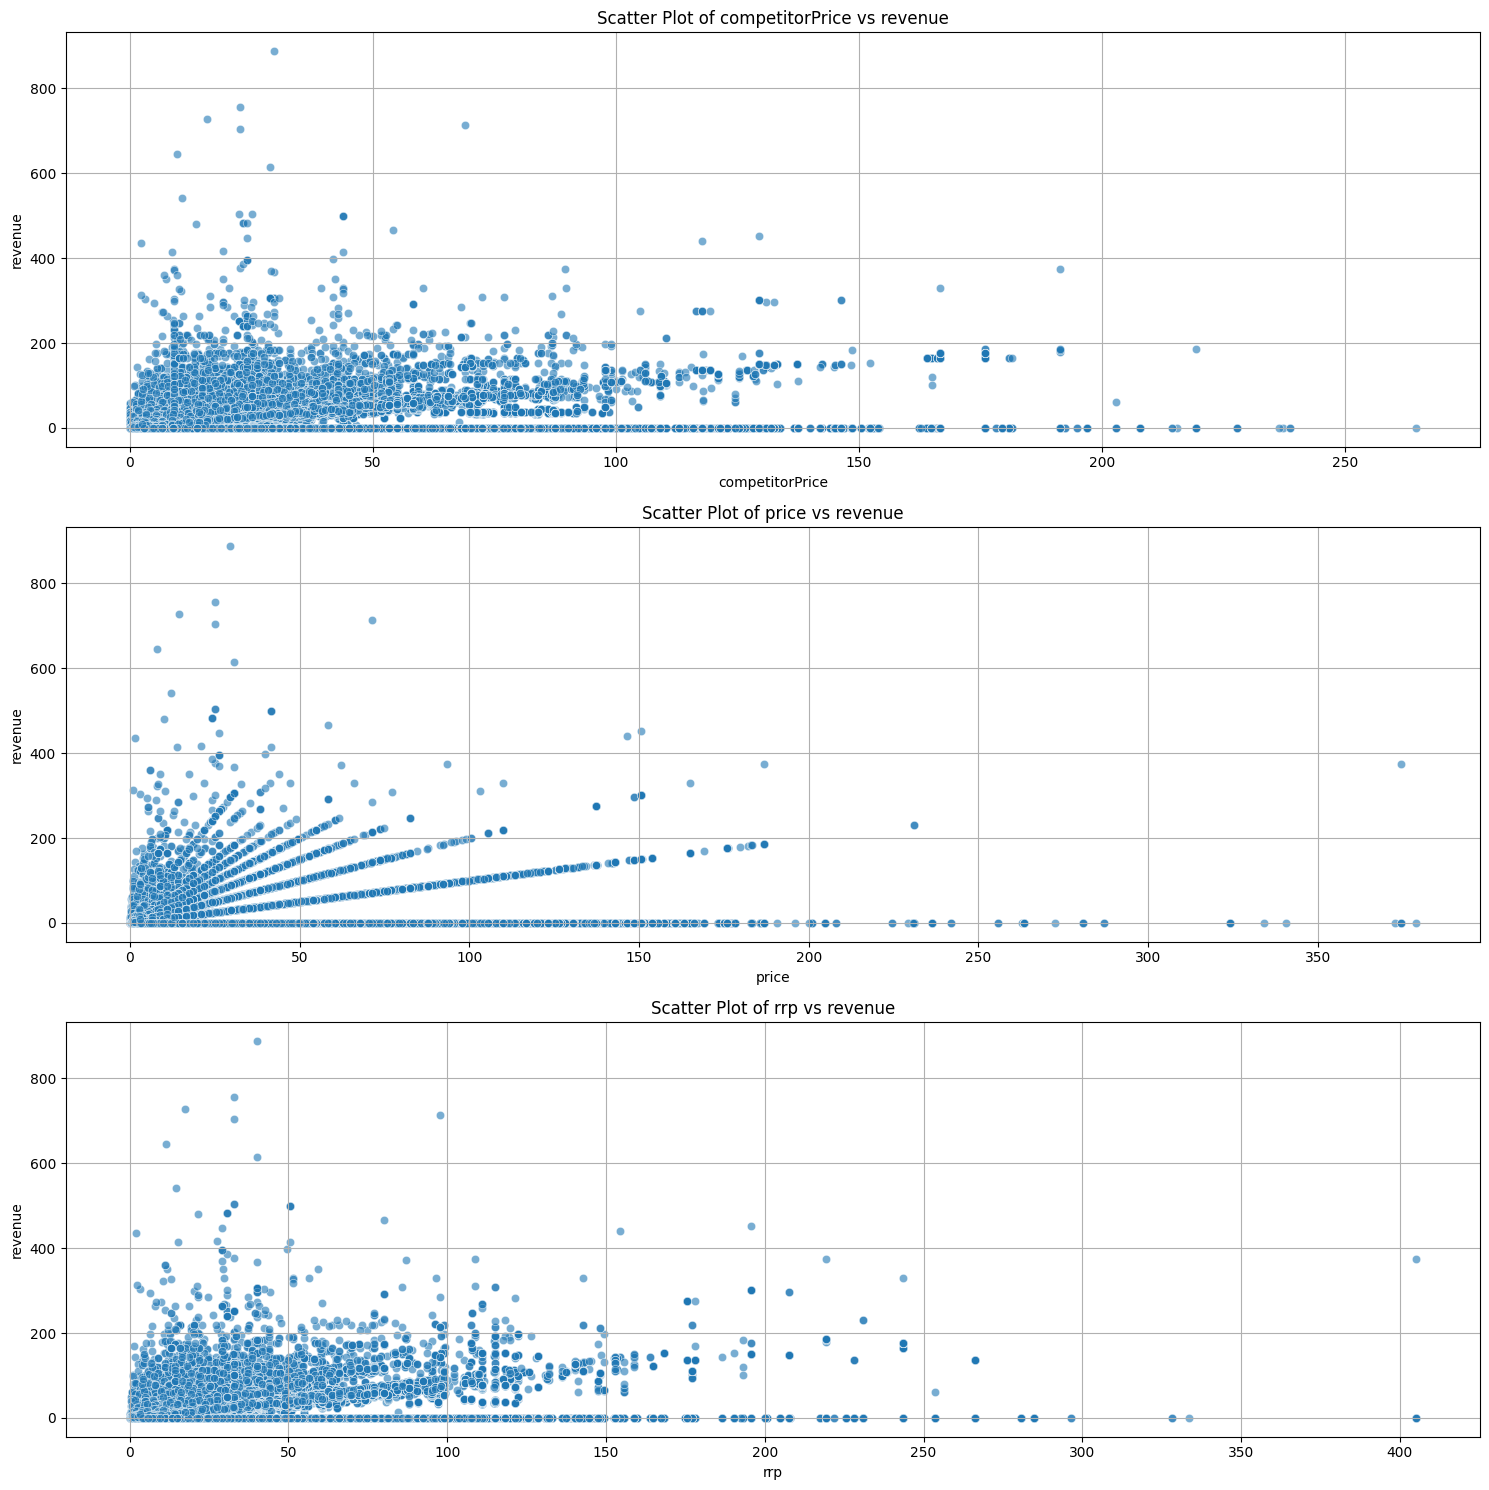

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame 'df' - replace this with your actual DataFrame
# df = pd.read_csv('your_data.csv') # Load your dataset

# Define your ratio features and the revenue column
ratio_features = ['competitorPrice', 'price', 'rrp']  # Replace with actual column names
revenue_column = 'revenue'  # Replace with the actual revenue column name

# Scatter plot for each ratio feature vs revenue
plt.figure(figsize=(15, 5 * len(ratio_features)))
for i, feature in enumerate(ratio_features, 1):
    plt.subplot(len(ratio_features), 1, i)
    sns.scatterplot(data=data_new, x=feature, y=revenue_column, alpha=0.6)
    plt.title(f'Scatter Plot of {feature} vs {revenue_column}')
    plt.xlabel(feature)
    plt.ylabel(revenue_column)
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Check for missing values in all columns
missing_values_per_column = data_new.isna().sum()

# Print the result
print(missing_values_per_column)

day                                    0
adFlag                                 0
availability                           0
competitorPrice                        0
price                                  0
content                                0
genericProduct                         0
rrp                                    0
group_grouped                          0
pharmForm_grouped                      0
manufacturer_grouped                   0
category_grouped                       0
total_clicks                           0
total_baskets                          0
total_orders                           0
click_to_basket_ratio                  0
basket_to_order_ratio                  0
click_to_order_ratio                   0
price_competitiveness                  0
price_rrp_ratio                        0
competitor_undercut_flag               0
revenue_per_click                      0
revenue_per_basket                     0
revenue_per_order                      0
price_availabili

In [ ]:
import numpy as np
import pandas as pd

# Check for infinity or very large values in X_train and X_val
# Ensure data_new does not contain infinity or very large values before training
def check_inf_and_large_values(df):
    # Check for infinity values
    inf_values = np.isinf(df).sum()
    print("\nInfinity values per column:\n", inf_values)

    # Check for values too large for float32 (around 3.4e+38)
    large_values = (np.abs(df) > np.finfo(np.float32).max).sum()
    print("\nValues exceeding float32 limit per column:\n", large_values)

    # Check for NaN values in the dataset again
    nan_values = df.isna().sum()
    print("\nNaN values per column:\n", nan_values)

# Perform checks on dataset
print("\nChecking data_new for issues:")
check_inf_and_large_values(data_new)




Checking data_new for issues:

Infinity values per column:
 day                                      0
adFlag                                   0
availability                             0
competitorPrice                          0
price                                    0
content                                  0
genericProduct                           0
rrp                                      0
group_grouped                            0
pharmForm_grouped                        0
manufacturer_grouped                     0
category_grouped                         0
total_clicks                             0
total_baskets                            0
total_orders                             0
click_to_basket_ratio                    0
basket_to_order_ratio                    0
click_to_order_ratio                     0
price_competitiveness                  976
price_rrp_ratio                          0
competitor_undercut_flag                 0
revenue_per_click                   

In [ ]:

import numpy as np
import pandas as pd

# Define a function to fix large and infinite values in the dataset
def fix_large_and_infinite_values(df):
    # Replace infinite values with NaN for easier handling
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Identify columns with values exceeding float32 limit
    float32_limit = np.finfo(np.float32).max
    large_values_mask = (np.abs(df) > float32_limit)

    # Set these large values to NaN
    df[large_values_mask] = np.nan

    # Replace NaN values (including former infinite and large values) with the median of the column
    for column in df.columns:
        if df[column].isna().sum() > 0:  # Check if NaN values are present
            median_value = df[column].median()
            df[column].fillna(median_value, inplace=True)
            print(f"Fixed column '{column}': replaced NaNs with median value {median_value}")

# Apply the function to your data
fix_large_and_infinite_values(data_new)


Fixed column 'price_competitiveness': replaced NaNs with median value 0.090909090909091


In [ ]:
import numpy as np

# Function to check for infinite and excessively large values in the dataset
def check_for_issues(df):
    # Check for infinite values
    infinite_mask = np.isinf(df.select_dtypes(include=[np.number]))
    infinite_cols = df.columns[infinite_mask.any()].tolist()

    if infinite_cols:
        print("Columns with infinite values:", infinite_cols)
    else:
        print("No infinite values found.")

    # Identify columns with values exceeding float32 limit
    float32_limit = np.finfo(np.float32).max
    large_values_mask = np.abs(df.select_dtypes(include=[np.number])) > float32_limit
    large_value_cols = df.columns[large_values_mask.any()].tolist()

    if large_value_cols:
        print("Columns with values exceeding float32 limit:", large_value_cols)
    else:
        print("No values exceeding float32 limit found.")

# Run the check function on datasets
print("Checking dataset:")
check_for_issues(data_new)



Checking dataset:
No infinite values found.
No values exceeding float32 limit found.


In [ ]:
data_new.columns

Index(['day', 'adFlag', 'availability', 'competitorPrice', 'price', 'content',
       'genericProduct', 'rrp', 'group_grouped', 'pharmForm_grouped',
       'manufacturer_grouped', 'category_grouped', 'total_clicks',
       'total_baskets', 'total_orders', 'click_to_basket_ratio',
       'basket_to_order_ratio', 'click_to_order_ratio',
       'price_competitiveness', 'price_rrp_ratio', 'competitor_undercut_flag',
       'revenue_per_click', 'revenue_per_basket', 'revenue_per_order',
       'price_availability_interaction', 'competitor_availability_interaction',
       'revenue'],
      dtype='object')

# Train Validation Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( data_new.drop(columns=["revenue"]), data_new[["revenue"]], test_size=0.2 )
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2204802, 25), (551201, 25), (2204802, 1), (551201, 1))

In [ ]:
X_train.head()

,adFlag,availability,competitorPrice,price,content,genericProduct,rrp,group_grouped,pharmForm_grouped,manufacturer_grouped,...,basket_to_order_ratio,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction
2387380,0,1,5.18,6.37,100.0,0,6.71,3,1.0,2,...,0.666666,3.833330,0.229730,0.949329,0,0.138478,0.796249,0.530833,6.37,5.18
749538,0,1,11.53,12.04,21.0,0,17.11,4,2.0,1,...,0.323529,2.735293,0.044232,0.703682,0,0.000000,0.000000,0.000000,12.04,11.53
278098,0,1,6.25,6.33,10.0,0,8.68,2,2.0,3,...,0.569697,2.260606,0.012800,0.729263,0,0.000000,0.000000,0.000000,6.33,6.25
2661495,1,1,4.38,4.90,10.0,0,7.08,2,1.0,4,...,0.508409,0.400172,0.118721,0.692090,0,0.010560,0.008312,0.004226,4.90,4.38
2554929,1,1,14.26,15.35,50.0,0,21.97,4,3.0,4,...,99.820950,1.626667,0.076438,0.698680,0,0.000000,0.000000,0.000000,15.35,14.26


# Catboost Regression Algorithm

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data_new.drop(columns=["revenue"]),
    data_new["revenue"],
    test_size=0.2,
    random_state=10
)

# Define cross-validation parameters and dataset pool
kf = KFold(n_splits=5, shuffle=True, random_state=10)
train_pool = Pool(data=X_train, label=y_train)

# Set CatBoost parameters for cross-validation
params = {
    'iterations': 100,
    'loss_function': 'RMSE',
    'custom_metric': ['RMSE', 'R2'],
    'random_seed': 10,
    'task_type': 'CPU',            # Use 'GPU' for GPU acceleration or 'CPU' to run on CPU
    'devices': '0',                # Specifies which GPU to use
    'eval_metric': 'RMSE'          # Set RMSE as primary metric for tuning
}

# Perform cross-validation
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=10,
    plot=True
)

# Extract best scores from cross-validation
best_rmse = np.min(cv_results['test-RMSE-mean'])
best_r2 = np.max(cv_results['test-R2-mean'])

print("Best CV RMSE:", best_rmse)
print("Best CV R2:", best_r2)

# Train the final model with the best parameters on full training set
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

# Predict and evaluate on validation set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("Validation RMSE:", val_rmse)
print("Validation R2:", val_r2)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.7210173	test: 10.5585408	best: 10.5585408 (0)	total: 78.7ms	remaining: 7.79s
1:	learn: 10.4788951	test: 10.3146834	best: 10.3146834 (1)	total: 159ms	remaining: 7.8s
2:	learn: 10.2468440	test: 10.0800497	best: 10.0800497 (2)	total: 231ms	remaining: 7.48s
3:	learn: 10.0224947	test: 9.8536096	best: 9.8536096 (3)	total: 302ms	remaining: 7.25s
4:	learn: 9.8068640	test: 9.6358186	best: 9.6358186 (4)	total: 369ms	remaining: 7.02s
5:	learn: 9.5998456	test: 9.4267351	best: 9.4267351 (5)	total: 438ms	remaining: 6.86s
6:	learn: 9.3993193	test: 9.2244219	best: 9.2244219 (6)	total: 512ms	remaining: 6.8s
7:	learn: 9.2056358	test: 9.0287522	best: 9.0287522 (7)	total: 580ms	remaining: 6.67s
8:	learn: 9.0188293	test: 8.8393829	best: 8.8393829 (8)	total: 651ms	remaining: 6.58s
9:	learn: 8.8413087	test: 8.6584469	best: 8.6584469 (9)	total: 722ms	remaining: 6.5s
10:	learn: 8.6662670	test: 8.4808837	best: 8.4808837 (10)	total: 793ms	remaining: 6.41s
11:	learn: 8.5002239	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 6.8588567	test: 6.6544367	best: 6.6544367 (0)	total: 109ms	remaining: 10.8s
1:	learn: 5.4984973	test: 5.3258688	best: 5.3258688 (1)	total: 214ms	remaining: 10.5s
2:	learn: 4.9154675	test: 4.7530999	best: 4.7530999 (2)	total: 325ms	remaining: 10.5s
3:	learn: 4.6213295	test: 4.4468929	best: 4.4468929 (3)	total: 421ms	remaining: 10.1s
4:	learn: 4.0535125	test: 3.9690271	best: 3.9690271 (4)	total: 519ms	remaining: 9.87s
5:	learn: 3.7217134	test: 3.6425597	best: 3.6425597 (5)	total: 622ms	remaining: 9.74s
6:	learn: 3.5488352	test: 3.4895196	best: 3.4895196 (6)	total: 710ms	remaining: 9.43s
7:	learn: 3.3842912	test: 3.3313008	best: 3.3313008 (7)	total: 783ms	remaining: 9.01s
8:	learn: 3.1224258	test: 3.0804170	best: 3.0804170 (8)	total: 873ms	remaining: 8.82s
9:	learn: 2.9498491	test: 2.8931888	best: 2.8931888 (9)	total: 955ms	remaining: 8.59s
10:	learn: 2.8252797	test: 2.7677255	best: 2.7677255 (10)	total: 1.03s	remaining: 8.36s
11:	learn: 2.6641927	test: 

# Hyperparameter Tuning of Catboost using Optuna


In [ ]:
pip install optuna

In [ ]:
pip install joblib

Trial metrics - RMSE: 2.101872008151537, R2: 0.957695819748567
Trial metrics - RMSE: 1.074830030530158, R2: 0.9886549705986901
Trial metrics - RMSE: 1.255058676866936, R2: 0.9845348673332117
Trial metrics - RMSE: 1.1079165361097674, R2: 0.987839677531422
Trial metrics - RMSE: 0.9167998219121726, R2: 0.9913431349911394
Trial metrics - RMSE: 1.0537710294345868, R2: 0.988930970663238
Trial metrics - RMSE: 1.308410873236428, R2: 0.9833987965124862
Trial metrics - RMSE: 2.051126794000967, R2: 0.9597543637130194
Trial metrics - RMSE: 1.3523939145133204, R2: 0.9822636024954183
Trial metrics - RMSE: 1.0543487914827434, R2: 0.988876220944109
Trial metrics - RMSE: 0.9845135792940916, R2: 0.9899941695904353
Trial metrics - RMSE: 0.9641478347257919, R2: 0.9903531868921064
Trial metrics - RMSE: 0.9827772959289621, R2: 0.990116983238952
Trial metrics - RMSE: 0.98536917651512, R2: 0.989965535120658
Trial metrics - RMSE: 1.7787346007730231, R2: 0.9694940472365149
Trial metrics - RMSE: 0.95859744819901

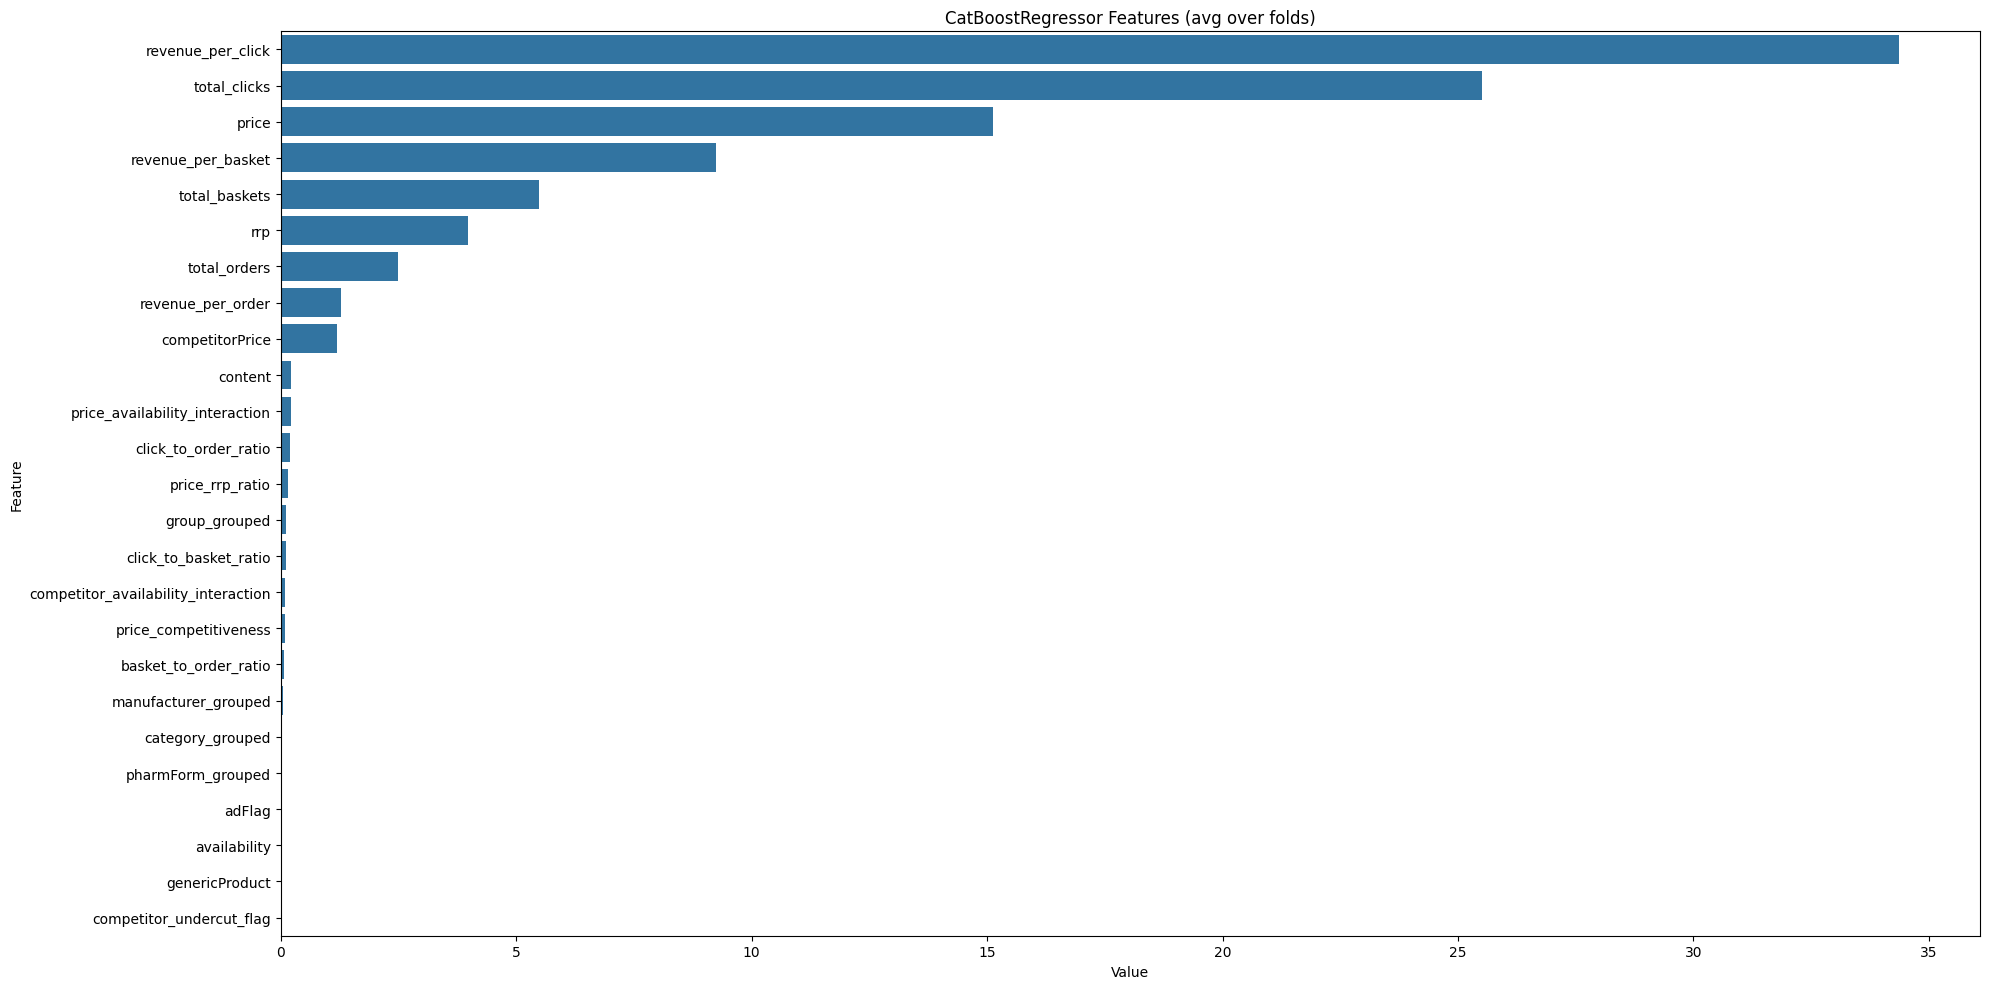

----------------------
Train RMSE: 0.32528509757341006
Train Normalized RMSE: revenue    0.000366
dtype: float64
Train R2 Score: 0.9989914822990649
-----
Validation RMSE: 0.8985298912269023
Validation Normalized RMSE: revenue    0.001464
dtype: float64
Validation R2 Score: 0.9922768744220732
----------------------


In [ ]:
# Import necessary libraries
import optuna
import joblib
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.5),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'RMSE',
        'custom_metric': ['RMSE', "R2"],
        'random_seed': 10,
        'use_best_model': True,
        'silent': True
    }

    # Initialize cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    rmse_scores = []
    r2_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_kf_train, X_kf_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_kf_train, y_kf_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model on each fold
        model = CatBoostRegressor(**params)
        model.fit(X_kf_train, y_kf_train, eval_set=(X_kf_val, y_kf_val), verbose=False)

        # Predict and calculate metrics for validation set
        y_pred = model.predict(X_kf_val)
        rmse = np.sqrt(mean_squared_error(y_kf_val, y_pred))
        r2 = r2_score(y_kf_val, y_pred)

        # Append scores
        rmse_scores.append(rmse)
        r2_scores.append(r2)

    # Average validation metrics over all folds
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    print(f"Trial metrics - RMSE: {avg_rmse}, R2: {avg_r2}")
    return avg_rmse  # Optuna minimizes RMSE by default

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Retrieve the best parameters
print("Best Params:", study.best_params)

# Train final model on full training set with best parameters
best_params = study.best_params
model = CatBoostRegressor(
    **best_params,
    loss_function='RMSE',
    custom_metric=['RMSE', "R2"],
    random_seed=10,
    silent=True
)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False)

# Plot Feature Importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('CatBoostRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(model, '/content/drive/MyDrive/models/Catboost_model.joblib')

# Load the model
model = joblib.load('/content/drive/MyDrive/models/Catboost_model.joblib')

# Calculate RMSE and R² on training and validation sets
print('----------------------')
y_train_pred = model.predict(X_train)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train Normalized RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)) / (y_train.max() - y_train.min()))
print("Train R2 Score:", r2_score(y_train, y_train_pred))
print('-----')
y_val_pred = model.predict(X_val)
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Validation Normalized RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)) / (y_val.max() - y_val.min()))
print("Validation R2 Score:", r2_score(y_val, y_val_pred))
print('----------------------')


# LightGBM Regression Algorithm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the model
model = lgb.LGBMRegressor(n_estimators=100, random_state=10)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=10)
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold + 1}")

    # Split the data
    X_kf_train, X_kf_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_kf_train, y_kf_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model on the training fold
    model.fit(X_kf_train, y_kf_train, eval_set=[(X_kf_val, y_kf_val)], eval_metric='rmse')

    # Predictions for the validation fold
    y_pred = model.predict(X_kf_val)

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(y_kf_val, y_pred))
    r2 = r2_score(y_kf_val, y_pred)

    # Store scores
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Print metrics for the fold
    print(f"Fold {fold + 1} RMSE: {rmse}")
    print(f"Fold {fold + 1} R2 Score: {r2}")

# Print average RMSE and R² across all folds
print("\nCross-Validation Results:")
print("Average RMSE:", np.mean(rmse_scores))
print("Average R2 Score:", np.mean(r2_scores))



Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4290
[LightGBM] [Info] Number of data points in the train set: 1763841, number of used features: 25
[LightGBM] [Info] Start training from score 3.751246
Fold 1 RMSE: 1.177712899618123
Fold 1 R2 Score: 0.9866683110572898

Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 1763841, number of used features: 25
[LightGBM] [Info] Start training from score 3.756017
Fold 2 RMSE: 1.122803771741779
Fold 2 R2 Score: 0.9878477683956322

Fold 3
[LightGBM] [Info] Auto-cho

# Hyperparameter Tuning LightGBM using Optuna

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 25
[LightGBM] [Info] Start training from score 3.749281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 2204802, number of used features: 25
[LightGBM] [Info] Start training from score 3.749281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train

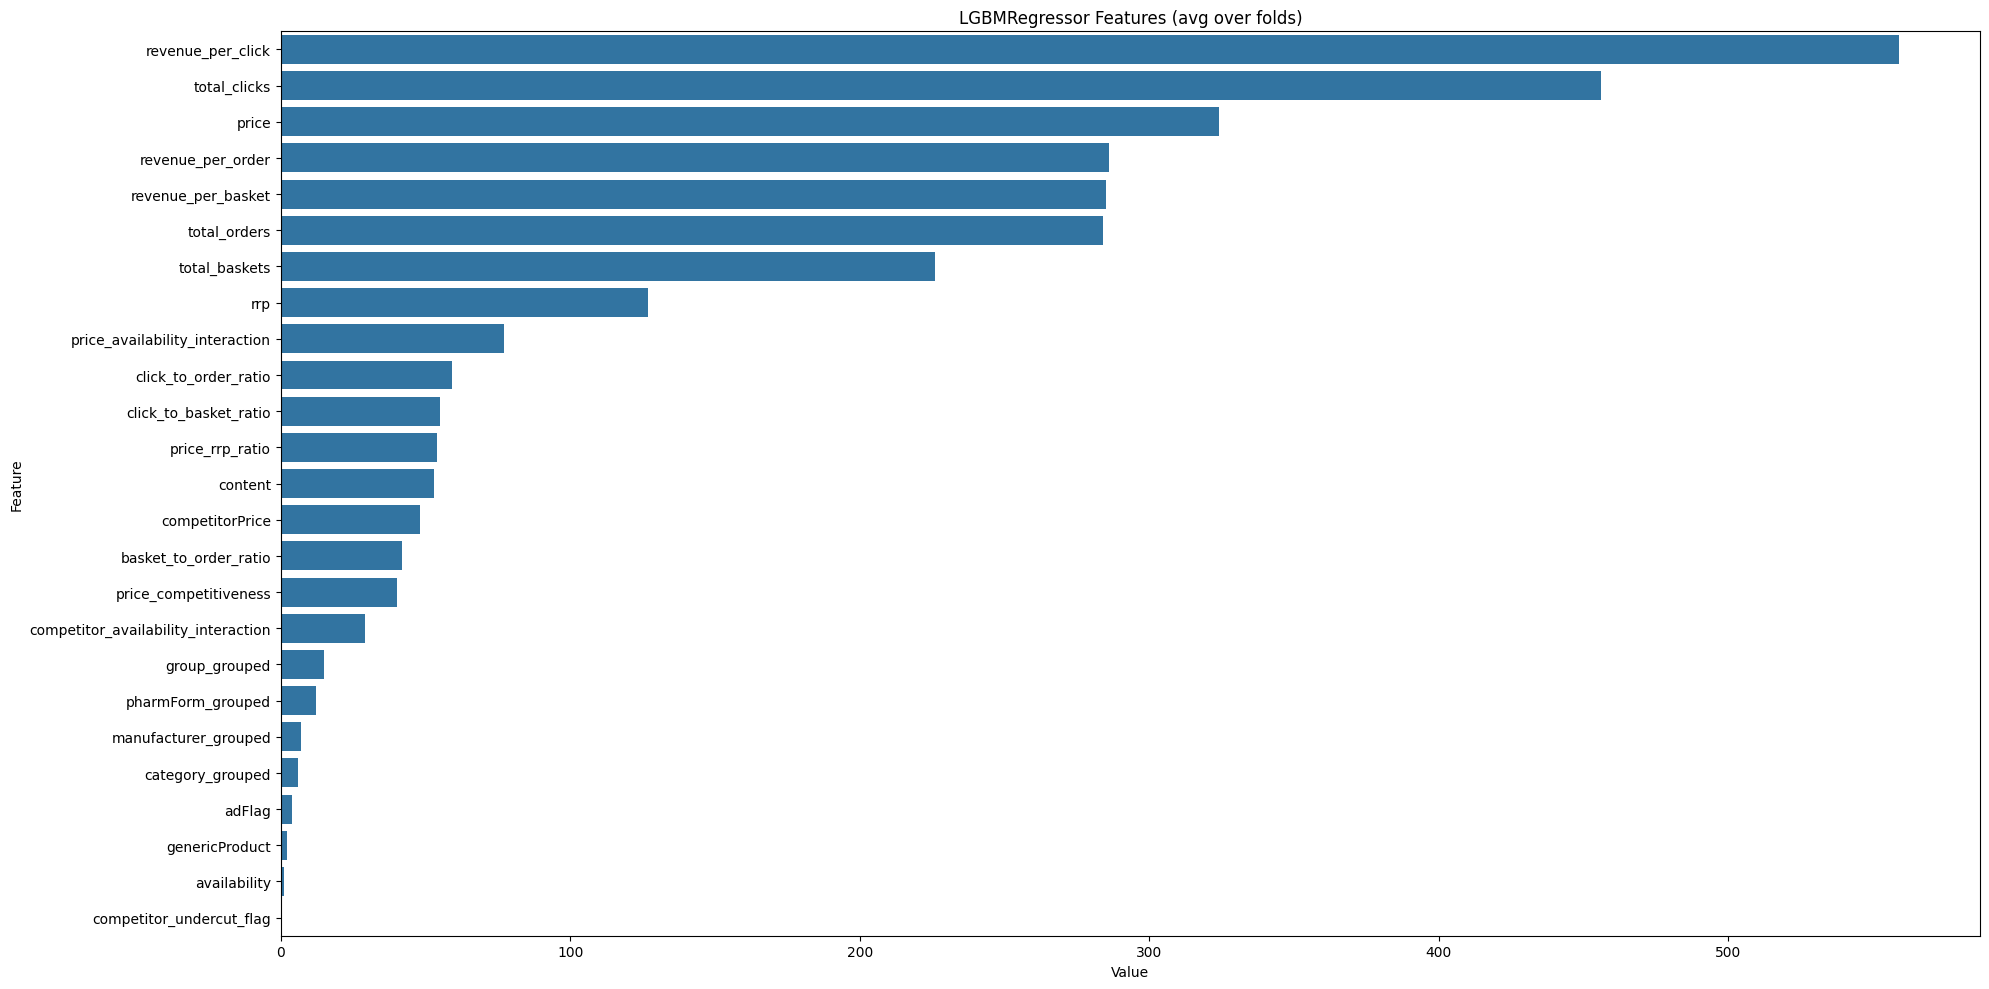

----------------------
Train RMSE: 0.9472683242933543
Train Normalized RMSE: revenue    0.001067
dtype: float64
Train R2 Score: 0.9914473397347542
-----
Validation RMSE: 1.0559988345168954
Validation Normalized RMSE: revenue    0.00172
dtype: float64
Validation R2 Score: 0.9893326900118545
----------------------


In [ ]:
import optuna
import joblib
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 4, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'random_state': 10
    }

    model = lgb.LGBMRegressor(**params)

    # Fit the model, specifying eval_metric inside fit()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate RMSE for validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse  # Return RMSE for optimization

# Optuna study to minimize RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Best parameters found
best_params = study.best_params
print("Best parameters:", best_params)

# Train the final model with the best parameters
model = lgb.LGBMRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    random_state=10
)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

# Feature Importance Plot
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBMRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()

# Save the model to a file
joblib.dump(model, "LGBM_model.joblib")

# Load the model from the file
model = joblib.load("LGBM_model.joblib")

# Evaluate the model on training and validation sets
print('----------------------')

# Training evaluation
y_pred_train = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_normalized_rmse = train_rmse / (y_train.max() - y_train.min())
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse}")
print(f"Train Normalized RMSE: {train_normalized_rmse}")
print(f"Train R2 Score: {train_r2}")

print('-----')

# Validation evaluation
y_pred_val = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_normalized_rmse = val_rmse / (y_val.max() - y_val.min())
val_r2 = r2_score(y_val, y_pred_val)

print(f"Validation RMSE: {val_rmse}")
print(f"Validation Normalized RMSE: {val_normalized_rmse}")
print(f"Validation R2 Score: {val_r2}")

print('----------------------')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Define the models
models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

# Iterate through models and evaluate
for model in models:
    try:
        model.fit(X_train, y_train.values.ravel())  # Fit the model, flatten y_train if needed
        # RMSE and R2 Score on train data
        y_pred_train = model.predict(X_train)
        print("\n", model.__class__.__name__, "Train RMSE = ", np.sqrt(mean_squared_error(y_train, y_pred_train)))
        print(model.__class__.__name__, "Train R2 Score = ", r2_score(y_train, y_pred_train))

        # RMSE and R2 Score on validation data
        y_pred_val = model.predict(X_val)
        print(model.__class__.__name__, "Validation RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred_val)))
        print(model.__class__.__name__, "Validation R2 Score = ", r2_score(y_val, y_pred_val))
        print("-----------------------------------------------------------------")
    except ValueError as e:
        print(f"Error occurred while fitting model {model.__class__.__name__}: {e}")



 DecisionTreeRegressor Train RMSE =  1.0661327150679243e-13
DecisionTreeRegressor Train R2 Score =  1.0
DecisionTreeRegressor Validation RMSE =  1.3986616587573029
DecisionTreeRegressor Validation R2 Score =  0.9813487869656292
-----------------------------------------------------------------

 RandomForestRegressor Train RMSE =  0.43597258272974776
RandomForestRegressor Train R2 Score =  0.9981868455502602
RandomForestRegressor Validation RMSE =  1.229357949747135
RandomForestRegressor Validation R2 Score =  0.985590847062271
-----------------------------------------------------------------

 AdaBoostRegressor Train RMSE =  13.983355212500799
AdaBoostRegressor Train R2 Score =  -0.8652593398251571
AdaBoostRegressor Validation RMSE =  13.945669415487338
AdaBoostRegressor Validation R2 Score =  -0.8542166432422258
-----------------------------------------------------------------

 GradientBoostingRegressor Train RMSE =  2.240681056287387
GradientBoostingRegressor Train R2 Score =  0.95

# Hyperparameter Tuning Xgboost Algorithm using Optuna

In [ ]:
import optuna
import numpy as np
import pickle
# Save the model using pickle
import joblib
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'min_child_weight': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'random_state': 10,
        'eval_metric': 'rmse'
    }
    model = XGBRegressor(**params)

    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Get predictions and calculate RMSE on the validation set
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Perform Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Train the model with the best parameters and early stopping
model = XGBRegressor(**study.best_trial.params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)



# Save the model to a file
joblib.dump(model, "/content/drive/MyDrive/models/tuned_xgboost.joblib")

# Metrics on train and validation data
y_pred_train = model.predict(X_train)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Train Normalized RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)) / (y_train.max() - y_train.min()))
print("Train R2 Score:", r2_score(y_train, y_pred_train))
print('-----')

y_pred_val = model.predict(X_val)
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("Validation Normalized RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)) / (y_val.max() - y_val.min()))
print("Validation R2 Score:", r2_score(y_val, y_pred_val))
print('----------------------')

# Cross-validation with best parameters
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Output cross-validation results
print("Cross-Validation RMSE:", -cv_rmse_scores.mean())
print("Cross-Validation RMSE Std Dev:", cv_rmse_scores.std())
print("Cross-Validation R2 Score:", cv_r2_scores.mean())
print("Cross-Validation R2 Score Std Dev:", cv_r2_scores.std())


Number of finished trials: 20
Best trial: {'n_estimators': 951, 'learning_rate': 0.06977109688311846, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.7136811349087048, 'colsample_bytree': 0.9233478496581567}
Train RMSE: 0.38031318861342656
Train Normalized RMSE: revenue    0.000428
dtype: float64
Train R2 Score: 0.99862140417099
-----
Validation RMSE: 0.7874830908483375
Validation Normalized RMSE: revenue    0.001283
dtype: float64
Validation R2 Score: 0.9940678477287292
----------------------
Cross-Validation RMSE: 0.8841851272455943
Cross-Validation RMSE Std Dev: 0.2734318339911913
Cross-Validation R2 Score: 0.9918931484222412
Cross-Validation R2 Score Std Dev: 0.00525419998991194


# Hyperparameter Tuning Random Forest Algorithm using Optuna

In [ ]:
import optuna
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 23),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 25),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1),
        'random_state': 10
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=-1)  # '-1' uses all available cores
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# Train the model with best parameters
model = RandomForestRegressor(**study.best_trial.params)
model.fit(X_train, y_train)

# Save the model using pickle
joblib.dump(model, "/content/drive/MyDrive/models/tuned_randomforest.joblib")


# Metrics on train and validation data
y_pred = model.predict(X_train)
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred)))
print("Train Normalized RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred))/(y_train.max()-y_train.min()))
print("Train R2 Score: ", r2_score(y_train, y_pred))
print('-----')
y_pred = model.predict(X_val)
print("Validation RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred)))
print("Validation Normalized RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred))/(y_val.max()-y_val.min()))
print("Validation R2 Score: ", r2_score(y_val, y_pred))
print('----------------------')

Number of finished trials: 10
Best trial: {'n_estimators': 171, 'max_depth': 17, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': 0.8499481502595094}
Train RMSE:  1.004965595597679
Train Normalized RMSE:  revenue    0.001132
dtype: float64
Train R2 Score:  0.9903737401881497
-----
Validation RMSE:  1.355489314218416
Validation Normalized RMSE:  revenue    0.002208
dtype: float64
Validation R2 Score:  0.9824239922893311
----------------------


# Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

# Create model with added layers and dropout for better regularization
model = Sequential()
model.add(Dense(2048, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Added dropout to help with overfitting

model.add(Dense(1024, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(BatchNormalization())

model.add(Dense(128, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(BatchNormalization())

model.add(Dense(64, activation=LeakyReLU(alpha=0.1), kernel_initializer=HeUniform()))
model.add(Dense(1, activation='linear'))  # 'linear' activation for regression output

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# Early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-10, mode="min")

# Train the model
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_val, y_val), callbacks=[early_stop, reduce_lr], batch_size=1024)

# Predictions
y_pred = model.predict(X_val)

# R2 Score
print("\nR2 Score = ", r2_score(y_val, y_pred))

# Save the model
model.save('dnn_model.h5')


Epoch 1/300
2154/2154 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 104.1032 - root_mean_squared_error: 10.2026 - val_loss: 100.0716 - val_root_mean_squared_error: 10.0036 - learning_rate: 1.0000e-04
Epoch 2/300
2154/2154 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 96.9426 - root_mean_squared_error: 9.8453 - val_loss: 101.2136 - val_root_mean_squared_error: 10.0605 - learning_rate: 1.0000e-04
Epoch 3/300
2154/2154 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 94.2846 - root_mean_squared_error: 9.7099 - val_loss: 99.3992 - val_root_mean_squared_error: 9.9699 - learning_rate: 1.0000e-04
Epoch 4/300
2154/2154 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 93.7006 - root_mean_squared_error: 9.6796 - val_loss: 98.0922 - val_root_mean_squared_error: 9.9042 - learning_rate: 1.0000e-04
Epoch 5/300
2154/2154 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 92.0749 - root_mean_squared_error: 9.5954 - val_loss: 97.1912 - val_root_mean_squared_error: 9.8586 - learning_rate: 1.0000e-04
Epoch 6/300
2154/2154 ━━━━━━━━━━━━


R2 Score =  0.5150243639945984


# Ensemble Learning | Simple Averaging

In [ ]:
X_train_catboost = X_train.copy()
X_val_catboost = X_val.copy()
X_train_light_gbm = X_train.copy()
X_val_light_gbm = X_val.copy()


In [ ]:
pip install catboost

In [ ]:
# Import necessary libraries
import joblib
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import LeakyReLU

# Register the LeakyReLU activation function
get_custom_objects().update({'LeakyReLU': LeakyReLU})

# Now load your model
loaded_model3 = load_model('/content/drive/MyDrive/models/dnn_model.h5')

# Load the models from disk using joblib
loaded_model = joblib.load("/content/drive/MyDrive/models/tuned_xgboost.joblib")
loaded_model1 = joblib.load("/content/drive/MyDrive/models/LGBM_model.joblib")
loaded_model2 = joblib.load("/content/drive/MyDrive/models/tuned_randomforest.joblib")
loaded_model3 = load_model('/content/drive/MyDrive/models/dnn_model.h5')
loaded_model4 = joblib.load("/content/drive/MyDrive/models/Catboost_model.joblib")

# Applying Ensemble Learning by taking average of all the models
# Predictions on Train data
y_pred = loaded_model.predict(X_train)
print(" Train RMSE | XGBoost :   ", np.sqrt(mean_squared_error(y_train, y_pred)))

y_pred1 = loaded_model1.predict(X_train_light_gbm)
print(" Train RMSE | Light GBM :  ", np.sqrt(mean_squared_error(y_train, y_pred1)))

y_pred2 = loaded_model2.predict(X_train)
print(" Train RMSE | Random Forest :  ", np.sqrt(mean_squared_error(y_train, y_pred2)))

y_pred3 = loaded_model3.predict(X_train)
y_pred3 = y_pred3.reshape(y_pred3.shape[0],)
print(" Train RMSE | DNN :  ", np.sqrt(mean_squared_error(y_train, y_pred3)))

y_pred4 = loaded_model4.predict(X_train_catboost)
print(" Train RMSE | Catboost :  ", np.sqrt(mean_squared_error(y_train, y_pred4)))

# Average of all the predictions
y_pred_final = (y_pred + y_pred1 + y_pred2 + y_pred3 + y_pred4) / 5

# Metrics on train data
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_final)))
print("Train Normalized RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_final)) / (y_train.max() - y_train.min()))
print("Train R2 Score: ", r2_score(y_train, y_pred_final))


 Train RMSE | XGBoost :    0.38031318861342656
 Train RMSE | Light GBM :   0.9472683242933543
 Train RMSE | Random Forest :   1.004965595597679
68901/68901 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step
 Train RMSE | DNN :   7.146247043434689
 Train RMSE | Catboost :   0.32528509757341006
Train RMSE:  1.5520041173284989
Train Normalized RMSE:  revenue    0.001748
dtype: float64
Train R2 Score:  0.9770416364461488


In [ ]:
# Predictions on Validation data
y_pred = loaded_model.predict(X_val)
print( " Validation RMSE | XGBoost :   ", np.sqrt(mean_squared_error(y_val, y_pred)) )
y_pred1 = loaded_model1.predict(X_val_light_gbm)
print( " Validation RMSE | Light GBM :  ", np.sqrt(mean_squared_error(y_val, y_pred1)) )
y_pred2 = loaded_model2.predict(X_val)
print( " Validation RMSE | Random Forest :  ", np.sqrt(mean_squared_error(y_val, y_pred2)) )
y_pred3 = loaded_model3.predict(X_val)
y_pred3 = y_pred3.reshape(y_pred3.shape[0],)
print( " Validation RMSE | DNN :  ", np.sqrt(mean_squared_error(y_val, y_pred3)) )
y_pred4 = loaded_model4.predict(X_val_catboost)
print( " Validation RMSE | Catboost :  ", np.sqrt(mean_squared_error(y_val, y_pred3)) )

y_pred_final = (y_pred + y_pred1 + y_pred2 + y_pred3 + y_pred4)/5

# Metrics on validation data
print("Validation RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred_final)))
print("Validation Normalized RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred_final))/(y_val.max()-y_val.min()))
print("Validation R2 Score: ", r2_score(y_val, y_pred_final))

 Validation RMSE | XGBoost :    0.7874830908483375
 Validation RMSE | Light GBM :   1.0559988345168954
 Validation RMSE | Random Forest :   1.355489314218416
17226/17226 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
 Validation RMSE | DNN :   7.090787932751805
 Validation RMSE | Catboost :   7.090787932751805
Validation RMSE:  1.667308884378059
Validation Normalized RMSE:  revenue    0.002716
dtype: float64
Validation R2 Score:  0.9734074388454379


***

In [ ]:
# # Predict on Test Data
# test_data['revenue'] = model.predict( test_data.drop(columns=['pid','actual_revenue']) )
# test_data['revenue'] = test_data['revenue'].apply(lambda x: 0 if x<0 else x)
# # RMSE
# from sklearn.metrics import mean_squared_error
# print( "RMSE = " , np.sqrt( mean_squared_error( test_data['actual_revenue'], test_data['revenue'] ) ) )
# # R2
# from sklearn.metrics import r2_score
# print( "R2 = " , r2_score( test_data['actual_revenue'], test_data['revenue'] ) )

# AutoML H2O

In [ ]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=aaedc45ddbc33701abe208a14c9b5c3fdf827fed5cfcf1583606b0d61dbcf51a
  Stored in directory: /root/.cache/pip/wheels/0c/95/eb/b449c73f478dbc4557b80170cf7f2aa6db15862877e9a63536
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpiw_oieuy
  JVM stdout: /tmp/tmpiw_oieuy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpiw_oieuy/h2o_unknownUser_started

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_wx9nm2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = data_new
data.to_csv("dataset.csv")
data

,adFlag,availability,competitorPrice,price,content,genericProduct,rrp,group_grouped,pharmForm_grouped,manufacturer_grouped,...,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction,revenue
0,0,2,14.60,16.89,50.0,0,18.25,4,2.0,2,...,8.499986,0.156849,0.925479,0,0.000000,0.000000,0.000000,33.78,29.20,0.00
1,1,1,8.57,8.75,50.0,1,18.81,2,4.0,4,...,2.836223,0.021004,0.465178,0,0.000000,0.000000,0.000000,8.75,8.57,0.00
2,0,1,14.77,16.06,100.0,0,18.48,2,1.0,3,...,6.999977,0.087339,0.869048,0,0.000000,0.000000,0.000000,16.06,14.77,0.00
3,1,1,6.59,6.55,60.0,0,9.31,3,3.0,4,...,3.628615,-0.006070,0.703545,1,0.001374,0.008722,0.004985,6.55,6.59,6.55
4,0,1,4.39,4.14,50.0,0,8.13,2,1.0,3,...,1.482014,-0.056948,0.509225,1,0.020097,0.041818,0.029784,4.14,4.39,4.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755998,0,1,22.41,18.64,15.0,0,24.75,2,2.0,1,...,8.142846,-0.168228,0.753131,1,0.000000,0.000000,0.000000,18.64,22.41,0.00
2755999,0,1,36.87,43.18,200.0,0,46.09,1,3.0,4,...,13.619041,0.171142,0.936863,0,0.000000,0.000000,0.000000,43.18,36.87,0.00
2756000,0,1,4.71,5.59,25.0,0,5.88,1,2.0,2,...,2.999998,0.186837,0.950680,0,0.000000,0.000000,0.000000,5.59,4.71,0.00
2756001,1,1,6.59,6.33,50.0,0,9.58,3,3.0,4,...,1.178650,-0.039454,0.660752,1,0.000000,0.000000,0.000000,6.33,6.59,0.00


In [ ]:
data = h2o.import_file(path="dataset.csv")
data

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


C1,adFlag,availability,competitorPrice,price,content,genericProduct,rrp,group_grouped,pharmForm_grouped,manufacturer_grouped,category_grouped,total_clicks,total_baskets,total_orders,click_to_basket_ratio,basket_to_order_ratio,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction,revenue
0,0,2,14.6,16.89,50,0,18.25,4,2,2,2,51,7,6,7.2857,1.16666,8.49999,0.156849,0.925479,0,0,0,0,33.78,29.2,0
1,1,1,8.57,8.75,50,1,18.81,2,4,4,4,1472,342,519,4.30409,0.65896,2.83622,0.0210035,0.465178,0,0,0,0,8.75,8.57,0
2,0,1,14.77,16.06,100,0,18.48,2,1,3,2,21,3,3,6.99998,0.999997,6.99998,0.0873392,0.869048,0,0,0,0,16.06,14.77,0
3,1,1,6.59,6.55,60,0,9.31,3,3,4,4,4768,751,1314,6.34887,0.571537,3.62861,-0.0060698,0.703545,1,0.00137374,0.0087217,0.00498478,6.55,6.59,6.55
4,0,1,4.39,4.14,50,0,8.13,2,1,3,1,206,99,139,2.08081,0.71223,1.48201,-0.0569476,0.509225,1,0.0200971,0.0418182,0.0297842,4.14,4.39,4.14
5,0,1,13.66,10.03,1000,0,21.6,2,3,3,1,174,113,188,1.53982,0.601064,0.925532,-0.265739,0.464352,1,0.0576437,0.0887611,0.0533511,10.03,13.66,10.03
6,1,1,3.03,3.58,20,0,5.62,3,3,4,4,612,1198,2205,0.510851,0.543311,0.277551,0.181518,0.637011,0,0.00584967,0.00298831,0.00162358,3.58,3.03,3.58
7,0,1,8.78,8.75,100,0,11.62,4,3,3,3,160,35,91,4.57143,0.384615,1.75824,-0.00341686,0.753012,1,0,0,0,8.75,8.78,0
8,0,1,10.84,12.04,50,0,14.19,4,4,1,3,250,22,58,11.3636,0.37931,4.31034,0.110701,0.848485,0,0,0,0,12.04,10.84,0
9,1,1,9.12,8.75,100,0,14.25,2,3,2,4,273,188,242,1.45213,0.776859,1.1281,-0.0405702,0.614035,1,0,0,0,8.75,9.12,0


In [ ]:
data.describe(chunk_summary=True)


Rows:2756003
Cols:27

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size       size_percentage
------------  -------------------------  -------  ------------------  ---------  -----------------
CBS           Binary                     67       7.75463             708.2 KB   0.248267
CXI           Sparse Integers            29       3.35648             1004.5 KB  0.35214
C1N           1-Byte Integers (w/o NAs)  160      18.5185             13.2 MB    4.72115
C2            2-Byte Integers            64       7.40741             10.5 MB    3.77543
C2S           2-Byte Fractions           155      17.9398             25.5 MB    9.14343
C4            4-Byte Integers            32       3.7037              10.5 MB    3.77468
C4S           4-Byte Fractions           5        0.578704            1.6 MB     0.591903
CUD           Unique Reals               32       3.7037              5.3 MB     1.90678
C8D           64-bit Reals               320      37.037              210.3 MB   75.4862

Frame distribution summary: 
                 size      number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  --------  ----------------  -----------------------------  ------------------
127.0.0.1:54321  278.6 MB  2.756e+06         32                             864
mean             278.6 MB  2.756e+06         32                             864
min              278.6 MB  2.756e+06         32                             864
max              278.6 MB  2.756e+06         32                             864
stddev           0  B      0                 0                              0
total            278.6 MB  2.756e+06         32                             864

,C1,adFlag,availability,competitorPrice,price,content,genericProduct,rrp,group_grouped,pharmForm_grouped,manufacturer_grouped,category_grouped,total_clicks,total_baskets,total_orders,click_to_basket_ratio,basket_to_order_ratio,click_to_order_ratio,price_competitiveness,price_rrp_ratio,competitor_undercut_flag,revenue_per_click,revenue_per_basket,revenue_per_order,price_availability_interaction,competitor_availability_interaction,revenue
type,int,int,int,real,real,real,int,real,int,int,int,int,int,int,int,real,real,real,real,real,int,real,real,real,real,real,real
mins,0.0,0.0,1.0,0.0,0.02,0.25,0.0,0.07,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.9966928482844152,0.013303769401330375,0.0,0.0,0.0,0.0,0.02,0.0,0.0
mean,1378001.0,0.31778884130387375,1.1110347122263673,12.634676976041016,13.85008329453924,119.2877109313742,0.10550859342315665,18.3090653566052,2.4999998185778463,2.39434463605446,2.4999998185778454,2.4524338326191972,592.6474093097858,1285.5409874372401,476.2768991906034,70884.3687460154,1035.737930932175,72630.07876812296,0.1268952701471545,0.7689212388496575,0.27790717208943533,142.5124876413157,2560.21888078202,0.11823992200231419,15.661756282558459,14.186698537701144,3.750979091822469
maxs,2756002.0,1.0,4.0,264.59,378.84,22000.0,1.0,404.97,4.0,4.0,4.0,4.0,5006.0,52406.0,8473.0,59599999.99999999,1400000.0,59599999.99999999,52.49707602339182,6.885496183206106,1.0,22484000.0,22484000.0,374.5862541374586,1136.52,793.77,887.7
sigma,795589.6813062624,0.4656169802648531,0.3921784910060503,12.537929096876613,13.623072835003063,477.77344228490983,0.3072076893260044,18.661680543950652,1.118034353854994,1.1442353649164991,1.118034353854994,1.1311271821573592,800.3400196093805,7235.053508115473,1032.2445749784777,1316324.8401525652,17276.705538352046,1385248.230806709,0.530797056862471,0.15127694982540496,0.4479674637788048,22445.73840176908,99807.75649240837,1.2238194401392573,18.59129573228628,16.10643513351848,10.239186423009313
zeros,1,1880176,0,976,0,0,2465221,0,0,0,0,0,541,41733,32868,541,41733,541,17462,0,1990090,2050913,2050913,2050913,0,976,2050913
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,0.0,2.0,14.6,16.89,50.0,0.0,18.25,4.0,2.0,2.0,2.0,51.0,7.0,6.0,7.28570387756589,1.1666647222254631,8.499985833356945,0.15684931506849323,0.9254794520547944,0.0,0.0,0.0,0.0,33.78,29.2,0.0
1,1.0,1.0,1.0,8.57,8.75,50.0,1.0,18.81,2.0,4.0,4.0,4.0,1472.0,342.0,519.0,4.304093441400777,0.6589595248755391,2.8362234520958873,0.021003500583430534,0.46517809675704413,0.0,0.0,0.0,0.0,8.75,8.57,0.0
2,2.0,0.0,1.0,14.77,16.06,100.0,0.0,18.48,2.0,1.0,3.0,2.0,21.0,3.0,3.0,6.999976666744444,0.9999966666777778,6.999976666744444,0.08733920108327686,0.869047619047619,0.0,0.0,0.0,0.0,16.06,14.77,0.0


In [ ]:
# Train Test Split
train, test = data.split_frame(ratios=[0.85], seed = 1)

# Identify predictors and response
x = data.columns
y = "revenue"
x.remove(y)

In [ ]:
AutoML = H2OAutoML(max_models=100, seed =10, max_runtime_secs=25000, project_name="Revenue_Forecast_for_Dynamic_Pricing") # 32000 9hrs # 42500 12hrs

In [ ]:
AutoML.train(x=x, y=y, training_frame=train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_1_20241031_73853


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    549                549                         436838                 6            6            5.91257       1             64            58.6157

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.11455037002000373
RMSE: 0.3384529066502513
MAE: 0.1260338363621259
RMSLE: NaN
Mean Residual Deviance: 0.11455037002000373

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.6076096130893749
RMSE: 0.7794931770640298
MAE: 0.1334317926334859
RMSLE: NaN
Mean Residual Deviance: 0.6076096130893749

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0           nan           nan           nan           nan           nan
loglikelihood           nan        0           nan           nan           nan           nan           nan
mae                     0.133432   0.00446924  0.129879      0.131104      0.137711      0.138829      0.129636
mean_residual_deviance  0.60761    0.34548     0.629179      0.340273      0.792955      1.06754       0.208103
mse                     0.60761    0.34548     0.629179      0.340273      0.792955      1.06754       0.208103
r2                      0.994185   0.00326704  0.993961      0.99672       0.992358      0.989894      0.997989
residual_deviance       0.60761    0.34548     0.629179      0.340273      0.792955      1.06754       0.208103
rmse                    0.751284   0.232332    0.793208      0.58333       0.89048       1.03322       0.456183
rmsle                   0.0634741  0           nan           nan           0.0634741     nan           nan

Scoring History: 
     timestamp            duration           number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  -----------------  -----------------  -------------------  -------------------  -------------------
     2024-10-31 12:20:53  34 min  3.881 sec  0.0                10.206076003223108   5.637747086594682    104.16398738356659
     2024-10-31 12:20:57  34 min  7.876 sec  5.0                7.160979526591819    3.6024895952023672   51.2796277802672
     2024-10-31 12:21:01  34 min 12.112 sec  10.0               5.268707956299862    2.2113436230947516   27.759283528777473
     2024-10-31 12:21:05  34 min 15.972 sec  15.0               4.15368337300346     1.4284100788569731   17.2530855631654
     2024-10-31 12:21:09  34 min 19.676 sec  20.0               3.223653314784784    0.9969884212235886   10.391940693922926
     2024-10-31 12:21:13  34 min 23.374 sec  25.0               2.595612143789362    0.7554250354199739   6.737202400986806
     2024-10-31 12:21:17  34 min 27.447 sec  30.0               2.1664185673705427   0.626566400948259    4.693369409047834
     2024-10-31 12:21:21  34 min 31.423 sec  35.0               1.8766986796207175   0.5485732024194062   3.5219979340901446
     2024-10-31 12:21:24  34 min 35.045 sec  40.0               1.6973102590330358   0.5017316135779962   2.880862115418791
     2024-10-31 12:21:28  34 min 38.717 sec  45.0               1.501290370633503    0.4574884361685602   2.253872776956881
---  ---                  ---                ---                ---                  ---                  ---
     2024-10-31 12:27:22  40 min 32.629 sec  505.0              0.35208621123236783  0.12984453456830816  0.12396470013996352
   

In [ ]:
automl_leaderboard = AutoML.leaderboard
automl_leaderboard.head(rows=automl_leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_5_AutoML_1_20241031_73853,0.779493,0.60761,0.133432,nan,0.60761
GBM_2_AutoML_1_20241031_73853,0.855364,0.731648,0.159793,nan,0.731648
GBM_3_AutoML_1_20241031_73853,0.912014,0.831769,0.15419,nan,0.831769
GBM_4_AutoML_1_20241031_73853,0.93465,0.873571,0.1686,nan,0.873571
GBM_1_AutoML_1_20241031_73853,1.31291,1.72374,0.10589,nan,1.72374
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.37635,1.89433,0.0708065,0.0208794,1.89433
XGBoost_3_AutoML_1_20241031_73853,1.43027,2.04566,0.203174,nan,2.04566
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.46727,2.15287,0.114644,nan,2.15287
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.50731,2.27199,0.140249,nan,2.27199
XGBoost_grid_1_AutoML_1_20241031_73853_model_2,1.53092,2.34372,0.108729,nan,2.34372


In [ ]:
best_model = AutoML.get_best_model()
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_1_20241031_73853


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    549                549                         436838                 6            6            5.91257       1             64            58.6157

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.11455037002000373
RMSE: 0.3384529066502513
MAE: 0.1260338363621259
RMSLE: NaN
Mean Residual Deviance: 0.11455037002000373

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.6076096130893749
RMSE: 0.7794931770640298
MAE: 0.1334317926334859
RMSLE: NaN
Mean Residual Deviance: 0.6076096130893749

Cross-Validation Metri

In [ ]:
train_evaluation = best_model.model_performance(train)
test_evaluation = best_model.model_performance(test)

print( "\n R2 Score on Training Set:  ", train_evaluation.r2() )
print( " R2 Score on Testing Set:  ", test_evaluation.r2() )
print( " \n RMSE Score on Training Set:  ", train_evaluation.rmse() )
print( " RMSE Score on Testing Set:  ", test_evaluation.rmse() )
print( " - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  ")


 R2 Score on Training Set:   0.9989002876284934
 R2 Score on Testing Set:   0.9955149564200273
 
 RMSE Score on Training Set:   0.3384529887462968
 RMSE Score on Testing Set:   0.6981562939001663
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  


In [ ]:
train_evaluation


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.11455042559130092
RMSE: 0.3384529887462968
MAE: 0.1260339270265047
RMSLE: NaN
Mean Residual Deviance: 0.11455042559130092

In [ ]:
test_evaluation


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.48742221071241537
RMSE: 0.6981562939001663
MAE: 0.13456247974437371
RMSLE: NaN
Mean Residual Deviance: 0.48742221071241537

### Saving Model

In [ ]:
# Assuming `best_model` is the model you want to save
model_path = h2o.save_model(model=best_model, path='/content/drive/MyDrive/model', force=True)
print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/model/GBM_5_AutoML_1_20241031_73853


In [ ]:
# Uninstall current H2O version
!pip uninstall -y h2o

# Install the compatible version
!pip install h2o==3.46.0.5


Found existing installation: h2o 3.46.0.6
Uninstalling h2o-3.46.0.6:
  Successfully uninstalled h2o-3.46.0.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=d1d59398d9a8801d6c29bbab65ffcdb5cec74f2bb22655268dcf29f23ae10284
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o


In [ ]:
import h2o

# Initialize the H2O server if it's not already running
h2o.init()

# Load your saved model if it's already in H2O or if it's loaded from H2O
# Replace `model_path` with your H2O model file path if required
model_path = "/content/drive/MyDrive/model/GBM_5_AutoML_1_20241031_73853"  # path to the H2O model if not loaded
model = h2o.load_model(model_path)

# Export the model to MOJO format
# Specify the destination folder and whether to also get the genmodel.jar file (for Java usage)
mojo_path = model.download_mojo(path=".", get_genmodel_jar=True)

print(f"MOJO file saved to: {mojo_path}")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpakf6a8qq
  JVM stdout: /tmp/tmpakf6a8qq/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpakf6a8qq/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_9ux9q3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


MOJO file saved to: /content/GBM_5_AutoML_1_20241031_73853.zip


In [ ]:
import h2o

# Initialize the H2O server if it's not already running
h2o.init()

# Load your saved model if it's already in H2O or if it's loaded from H2O
# Replace `model_path` with your H2O model file path if required
model_path = "./models/GBM_5_AutoML"  # path to the H2O model if not loaded
model = h2o.load_model(model_path)

# Export the model to MOJO format
# Specify the destination folder and whether to also get the genmodel.jar file (for Java usage)
mojo_path = model.download_mojo(path=".", get_genmodel_jar=True)

print(f"MOJO file saved to: {mojo_path}")


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_5_AutoML_1_20241031_73853,0.698156,0.487422,0.134562,nan,0.487422,418883,0.030043,GBM
GBM_2_AutoML_1_20241031_73853,0.838212,0.702599,0.157485,nan,0.702599,418519,0.031956,GBM
GBM_3_AutoML_1_20241031_73853,0.867004,0.751697,0.148904,nan,0.751697,375721,0.027322,GBM
GBM_4_AutoML_1_20241031_73853,0.927894,0.860988,0.172591,nan,0.860988,225961,0.016188,GBM
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.39924,1.95788,0.0678426,0.021278,1.95788,298972,0.005734,XGBoost
GBM_1_AutoML_1_20241031_73853,1.47066,2.16285,0.102996,nan,2.16285,595380,0.036199,GBM
XGBoost_3_AutoML_1_20241031_73853,1.47078,2.16321,0.204073,nan,2.16321,147275,0.002288,XGBoost
DRF_1_AutoML_1_20241031_73853,1.5111,2.28341,0.103356,0.0351367,2.28341,115462,0.004395,DRF
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.5235,2.32106,0.111028,nan,2.32106,172796,0.002551,XGBoost
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.55743,2.4256,0.135099,nan,2.4256,87109,0.002483,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

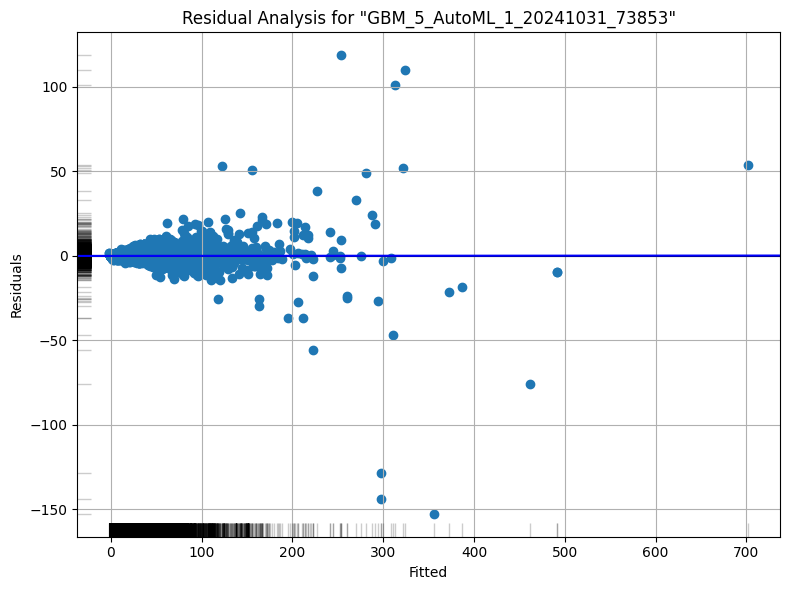

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

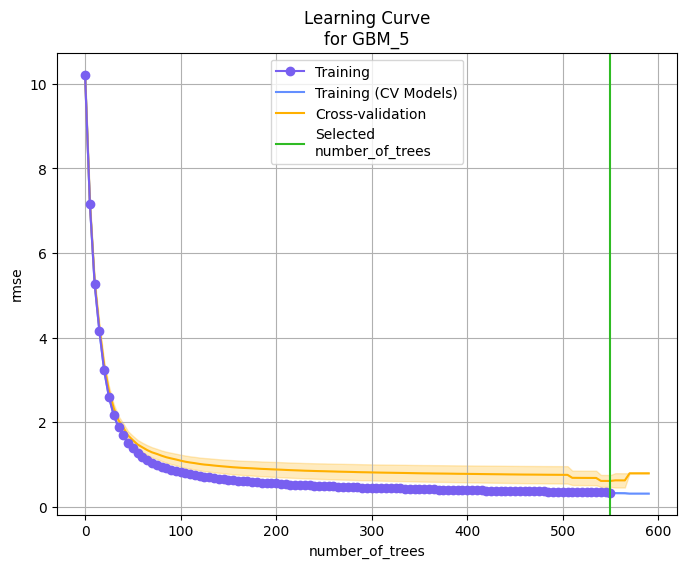

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

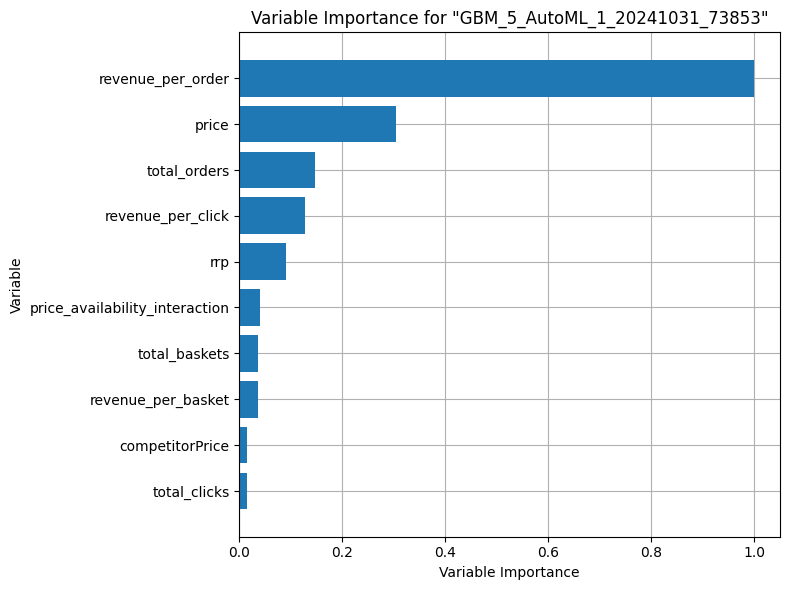

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

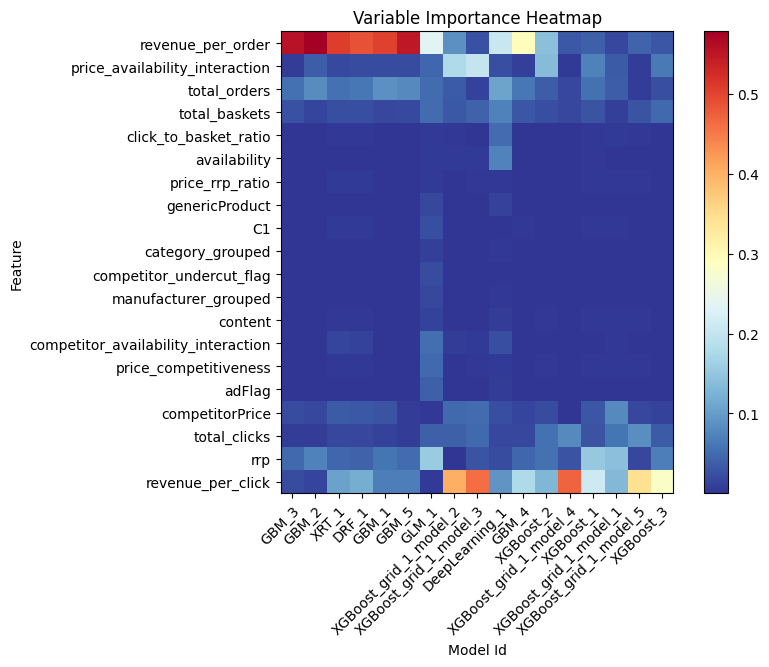

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

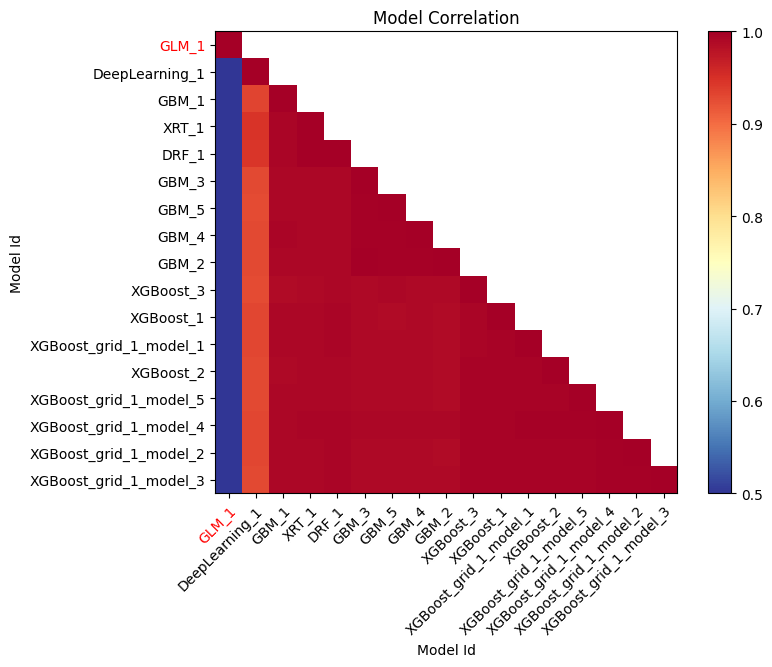

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

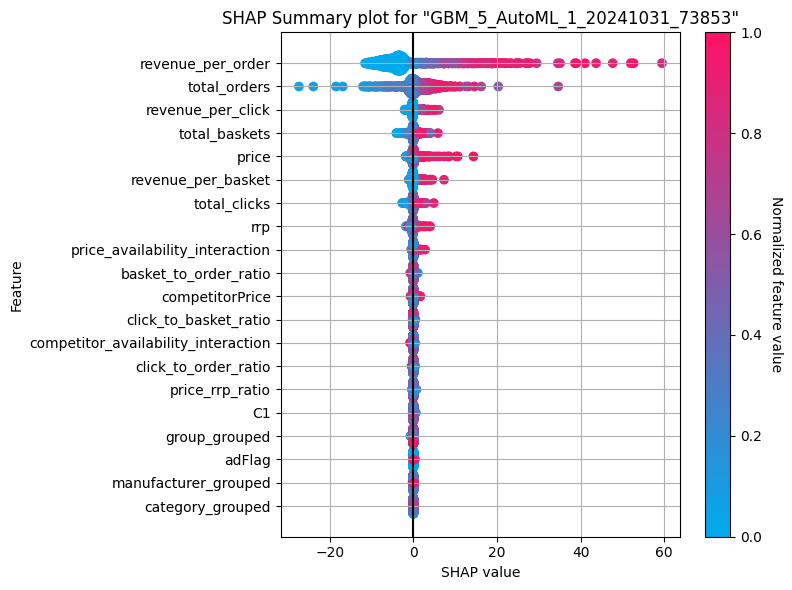

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

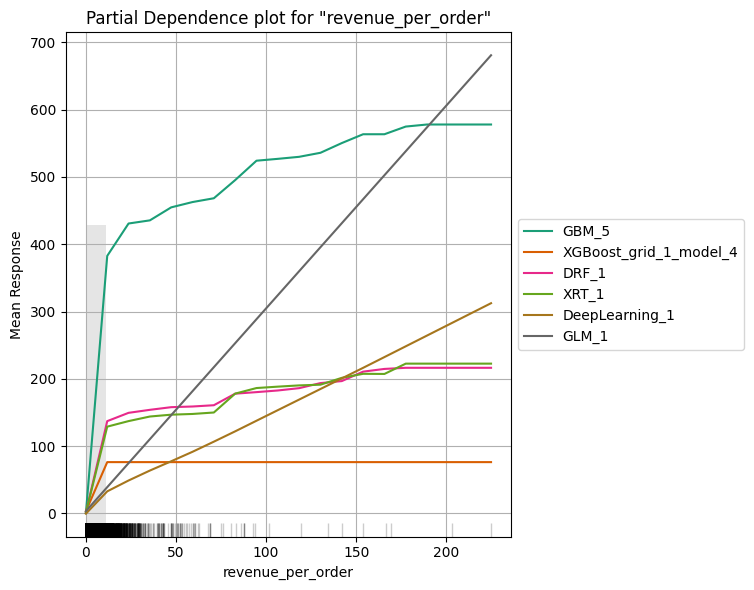

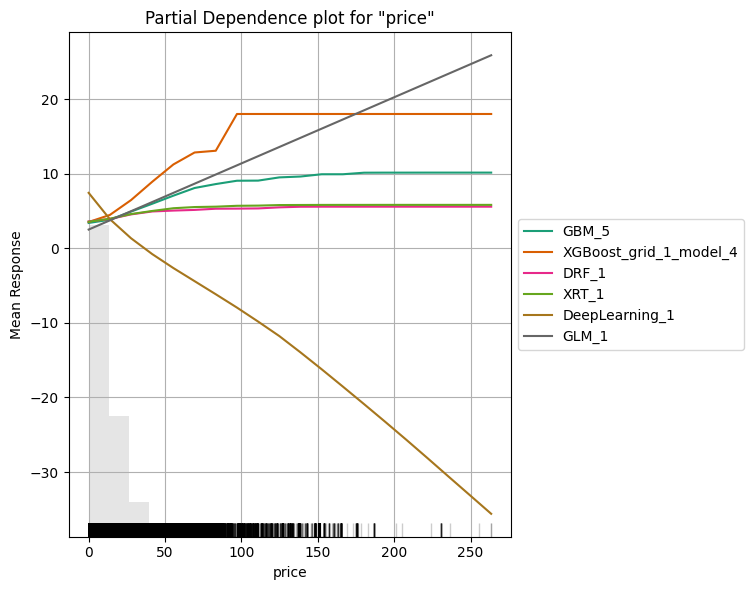

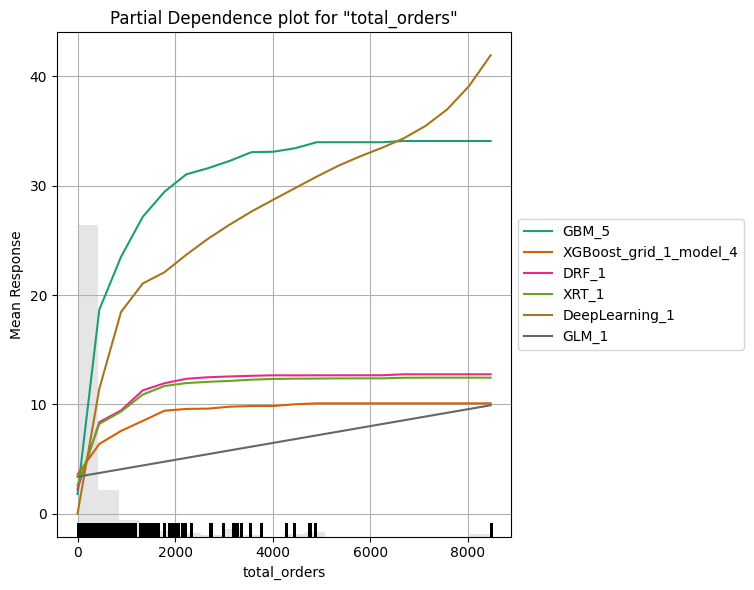

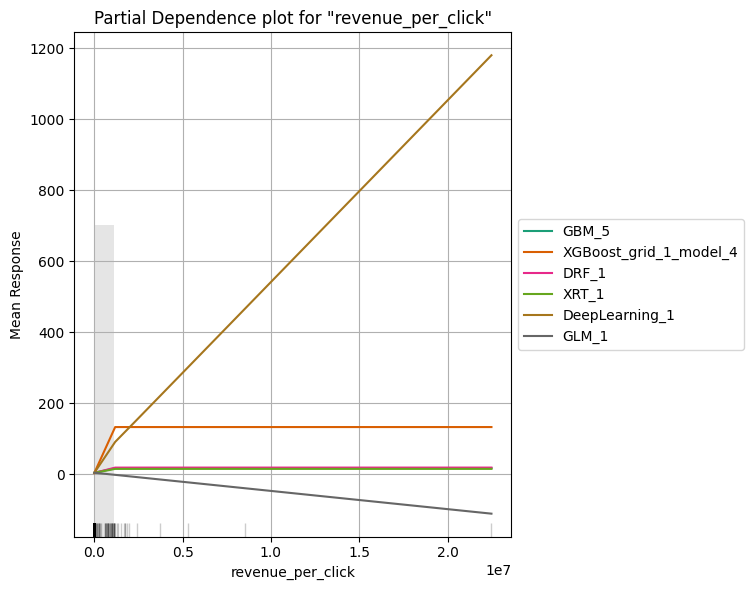

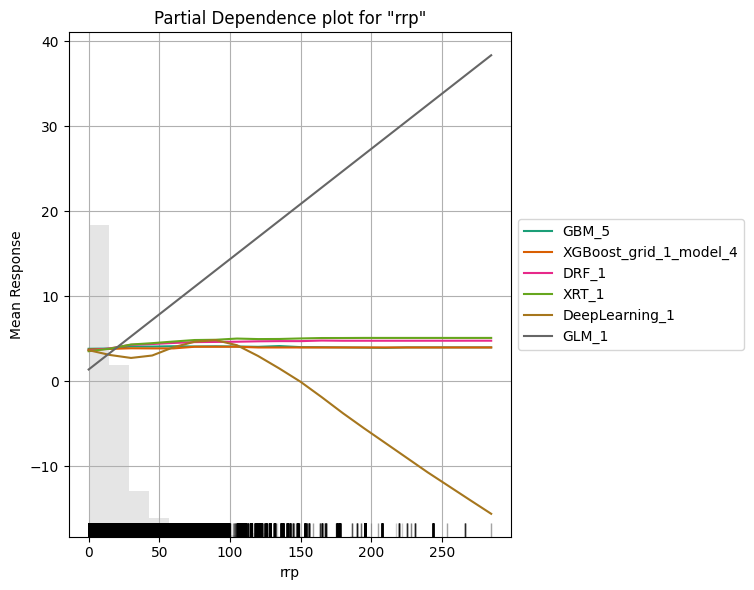

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

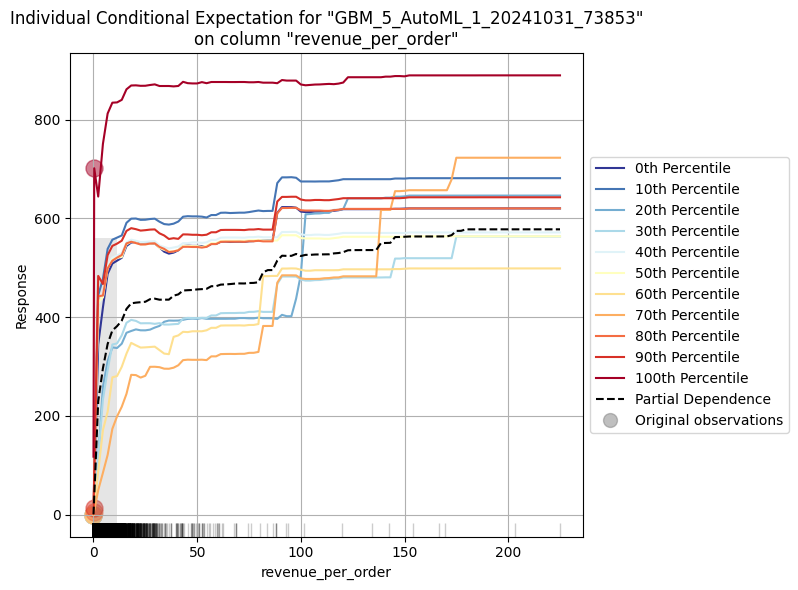

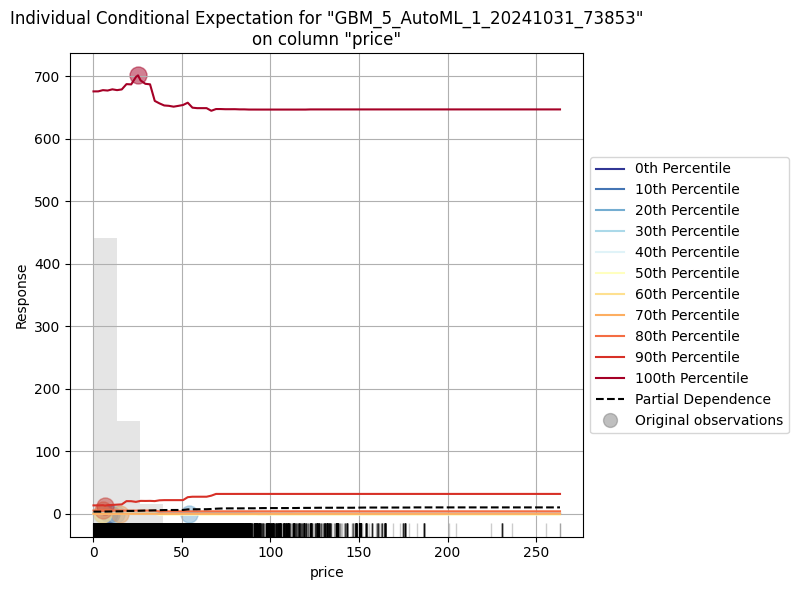

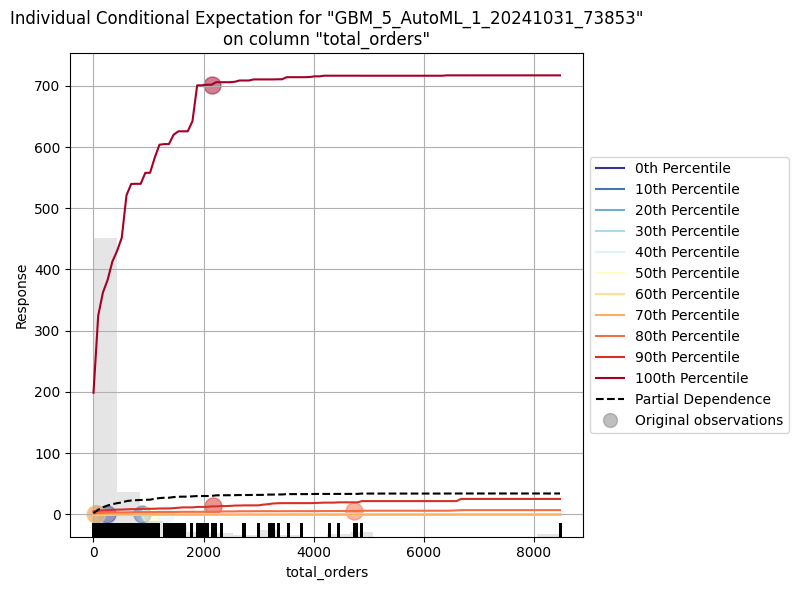

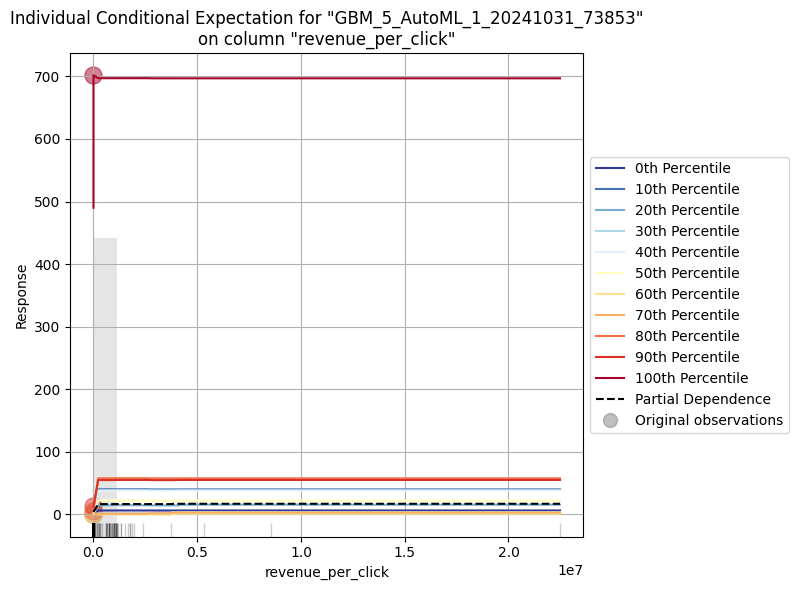

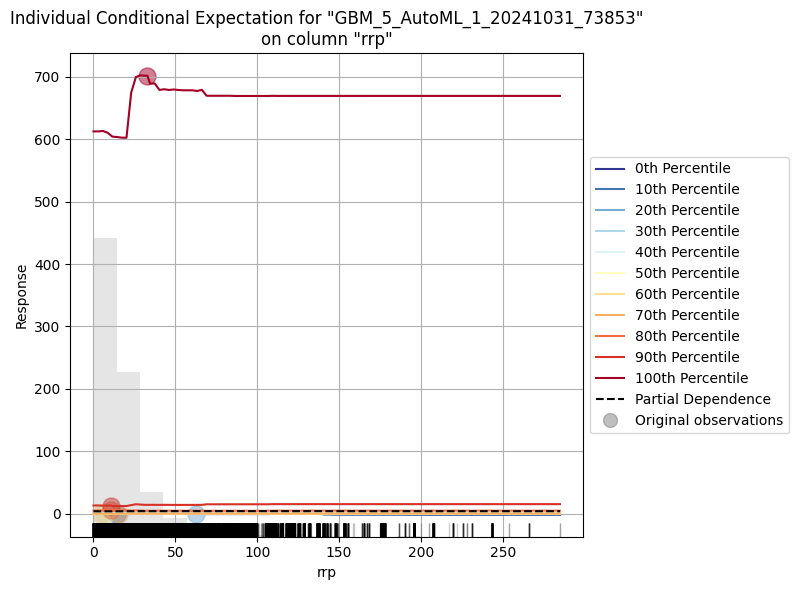

In [ ]:
explain_model = AutoML.explain(frame=test, figsize = (8,6))


# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo,predict
GBM_5_AutoML_1_20241031_73853,0.698156,0.487422,0.134562,nan,0.487422,418883,0.030043,GBM,-0.0976268
GBM_2_AutoML_1_20241031_73853,0.838212,0.702599,0.157485,nan,0.702599,418519,0.031956,GBM,-0.0875594
GBM_3_AutoML_1_20241031_73853,0.867004,0.751697,0.148904,nan,0.751697,375721,0.027322,GBM,-0.0127846
GBM_4_AutoML_1_20241031_73853,0.927894,0.860988,0.172591,nan,0.860988,225961,0.016188,GBM,0.099629
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.39924,1.95788,0.0678426,0.021278,1.95788,298972,0.005734,XGBoost,0.000407506
GBM_1_AutoML_1_20241031_73853,1.47066,2.16285,0.102996,nan,2.16285,595380,0.036199,GBM,-0.00379806
XGBoost_3_AutoML_1_20241031_73853,1.47078,2.16321,0.204073,nan,2.16321,147275,0.002288,XGBoost,0.0100026
DRF_1_AutoML_1_20241031_73853,1.5111,2.28341,0.103356,0.0351367,2.28341,115462,0.004395,DRF,0
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.5235,2.32106,0.111028,nan,2.32106,172796,0.002551,XGBoost,-0.000766985
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.55743,2.4256,0.135099,nan,2.4256,87109,0.002483,XGBoost,0.000820124


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

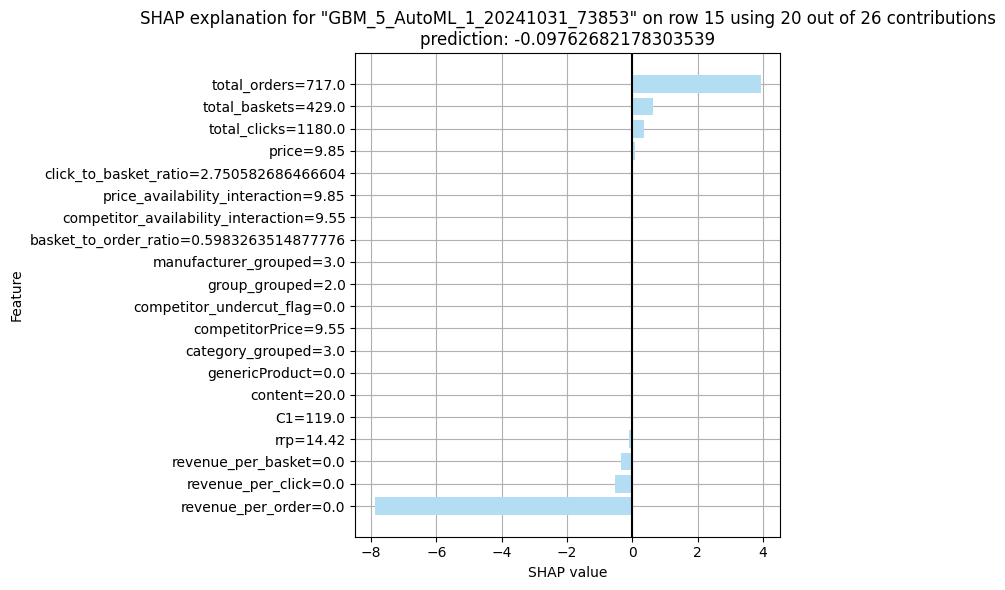

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo,predict
GBM_5_AutoML_1_20241031_73853,0.698156,0.487422,0.134562,nan,0.487422,418883,0.030043,GBM,-0.0976268
GBM_2_AutoML_1_20241031_73853,0.838212,0.702599,0.157485,nan,0.702599,418519,0.031956,GBM,-0.0875594
GBM_3_AutoML_1_20241031_73853,0.867004,0.751697,0.148904,nan,0.751697,375721,0.027322,GBM,-0.0127846
GBM_4_AutoML_1_20241031_73853,0.927894,0.860988,0.172591,nan,0.860988,225961,0.016188,GBM,0.099629
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.39924,1.95788,0.0678426,0.021278,1.95788,298972,0.005734,XGBoost,0.000407506
GBM_1_AutoML_1_20241031_73853,1.47066,2.16285,0.102996,nan,2.16285,595380,0.036199,GBM,-0.00379806
XGBoost_3_AutoML_1_20241031_73853,1.47078,2.16321,0.204073,nan,2.16321,147275,0.002288,XGBoost,0.0100026
DRF_1_AutoML_1_20241031_73853,1.5111,2.28341,0.103356,0.0351367,2.28341,115462,0.004395,DRF,0
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.5235,2.32106,0.111028,nan,2.32106,172796,0.002551,XGBoost,-0.000766985
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.55743,2.4256,0.135099,nan,2.4256,87109,0.002483,XGBoost,0.000820124


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

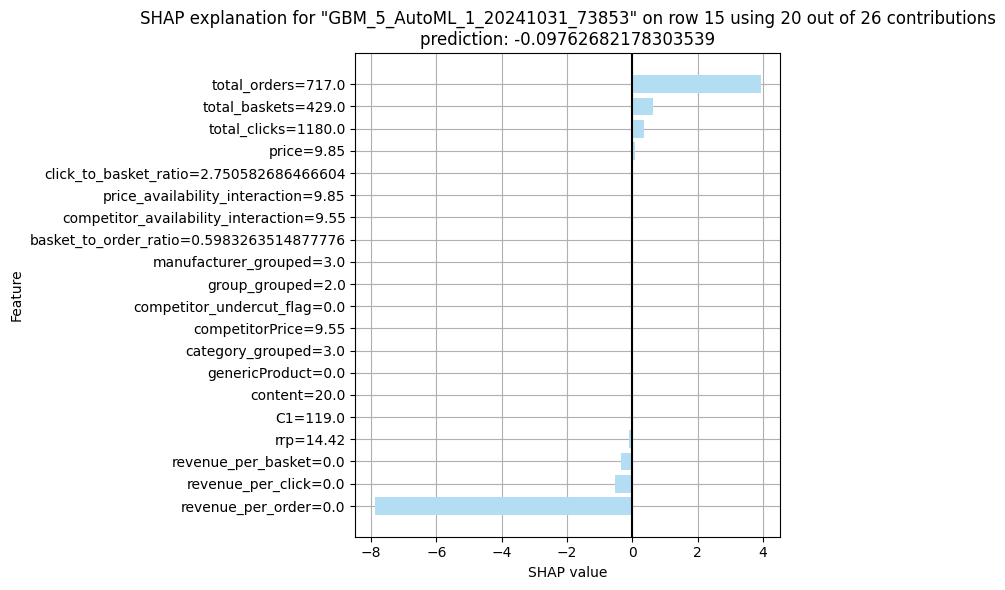

In [ ]:
AutoML.explain_row(frame = test, row_index = 15, figsize = (8,6))


In [ ]:
automl_leaderboard = AutoML.leaderboard
automl_leaderboard.head(rows=automl_leaderboard.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_5_AutoML_1_20241031_73853,0.779493,0.60761,0.133432,nan,0.60761
GBM_2_AutoML_1_20241031_73853,0.855364,0.731648,0.159793,nan,0.731648
GBM_3_AutoML_1_20241031_73853,0.912014,0.831769,0.15419,nan,0.831769
GBM_4_AutoML_1_20241031_73853,0.93465,0.873571,0.1686,nan,0.873571
GBM_1_AutoML_1_20241031_73853,1.31291,1.72374,0.10589,nan,1.72374
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.37635,1.89433,0.0708065,0.0208794,1.89433
XGBoost_3_AutoML_1_20241031_73853,1.43027,2.04566,0.203174,nan,2.04566
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.46727,2.15287,0.114644,nan,2.15287
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.50731,2.27199,0.140249,nan,2.27199
XGBoost_grid_1_AutoML_1_20241031_73853_model_2,1.53092,2.34372,0.108729,nan,2.34372


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_5_AutoML_1_20241031_73853,0.698156,0.487422,0.134562,nan,0.487422,418883,0.030043,GBM
GBM_2_AutoML_1_20241031_73853,0.838212,0.702599,0.157485,nan,0.702599,418519,0.031956,GBM
GBM_3_AutoML_1_20241031_73853,0.867004,0.751697,0.148904,nan,0.751697,375721,0.027322,GBM
GBM_4_AutoML_1_20241031_73853,0.927894,0.860988,0.172591,nan,0.860988,225961,0.016188,GBM
XGBoost_grid_1_AutoML_1_20241031_73853_model_4,1.39924,1.95788,0.0678426,0.021278,1.95788,298972,0.005734,XGBoost
GBM_1_AutoML_1_20241031_73853,1.47066,2.16285,0.102996,nan,2.16285,595380,0.036199,GBM
XGBoost_3_AutoML_1_20241031_73853,1.47078,2.16321,0.204073,nan,2.16321,147275,0.002288,XGBoost
DRF_1_AutoML_1_20241031_73853,1.5111,2.28341,0.103356,0.0351367,2.28341,115462,0.004395,DRF
XGBoost_grid_1_AutoML_1_20241031_73853_model_3,1.5235,2.32106,0.111028,nan,2.32106,172796,0.002551,XGBoost
XGBoost_grid_1_AutoML_1_20241031_73853_model_5,1.55743,2.4256,0.135099,nan,2.4256,87109,0.002483,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

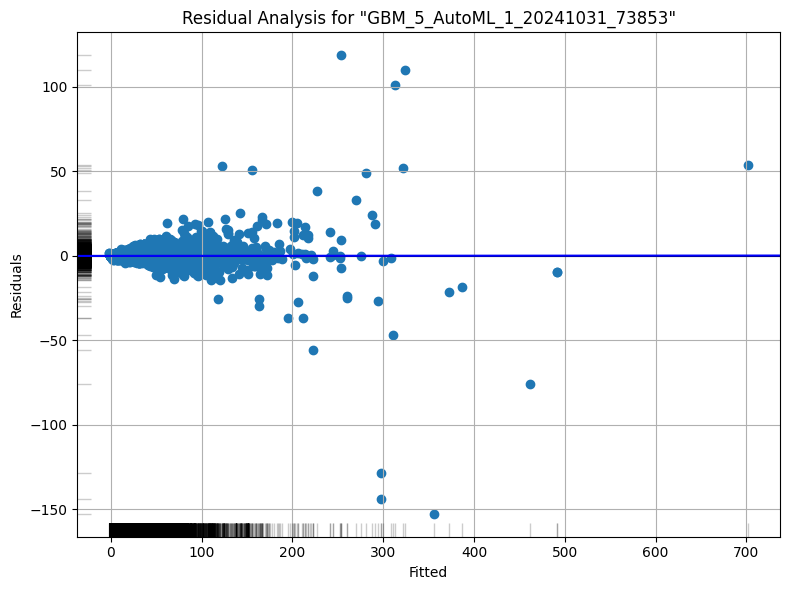

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

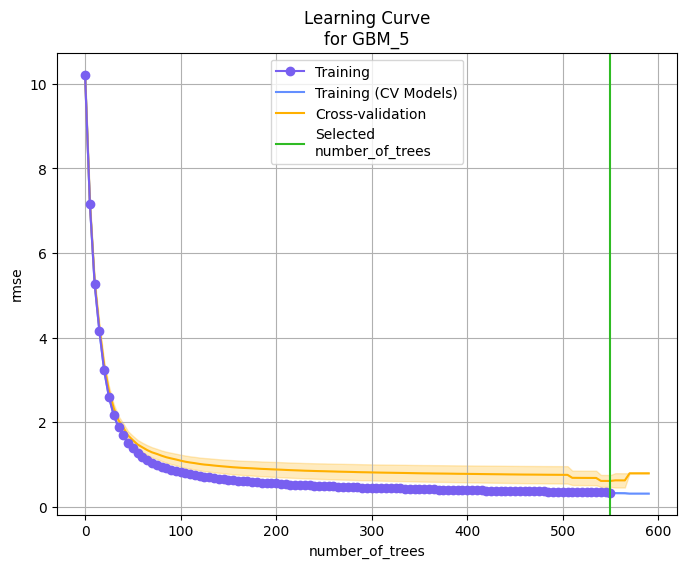

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

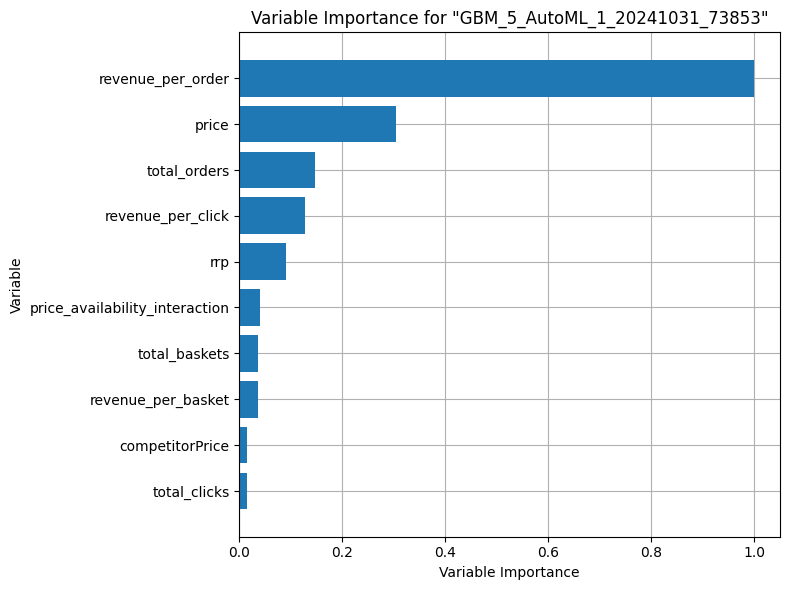

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

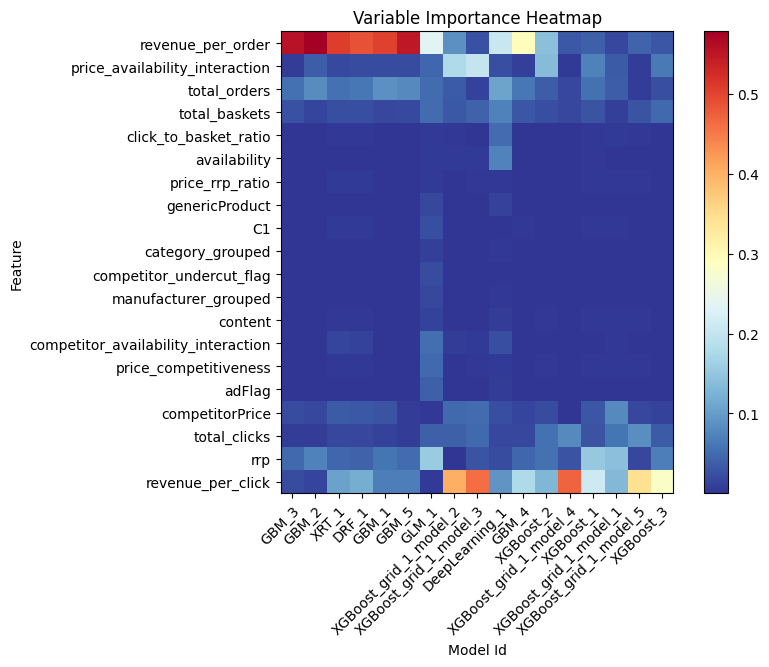

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

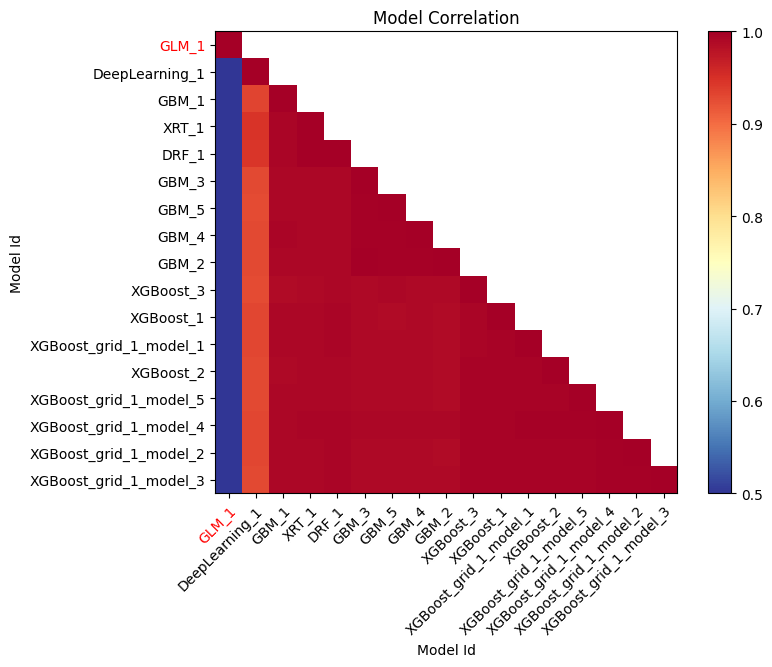

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

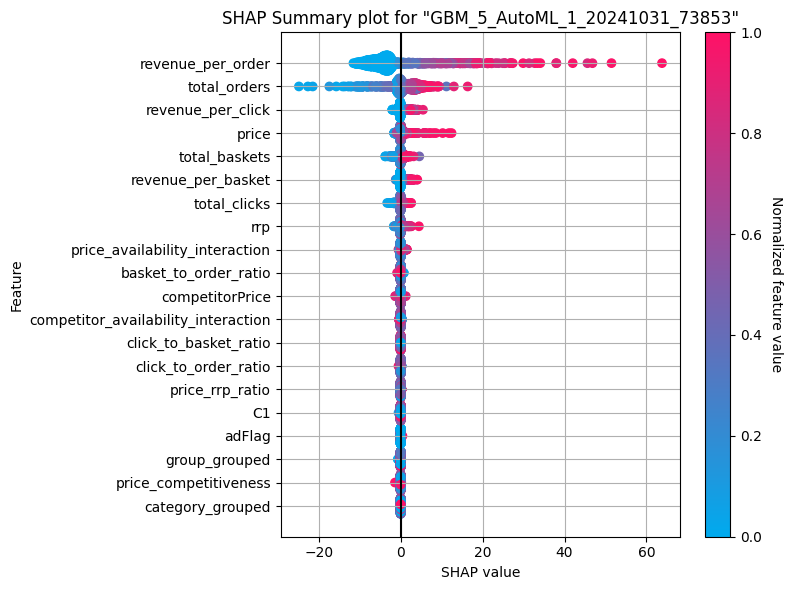

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

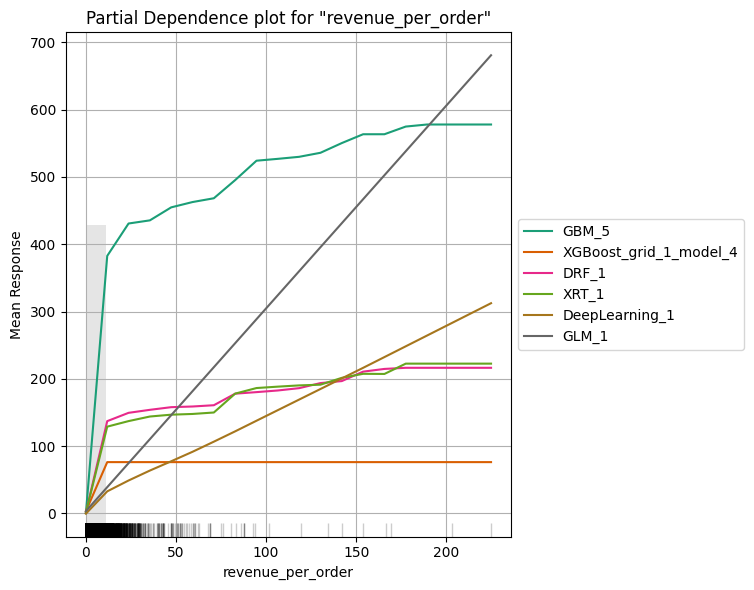

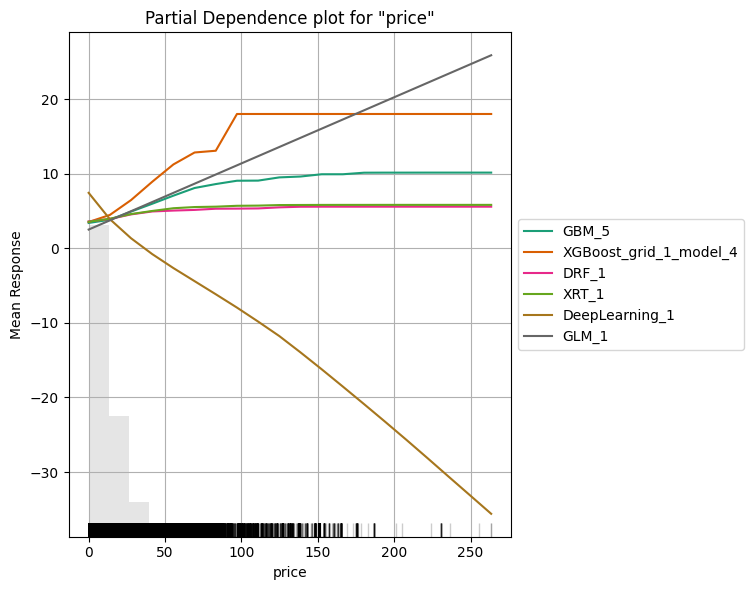

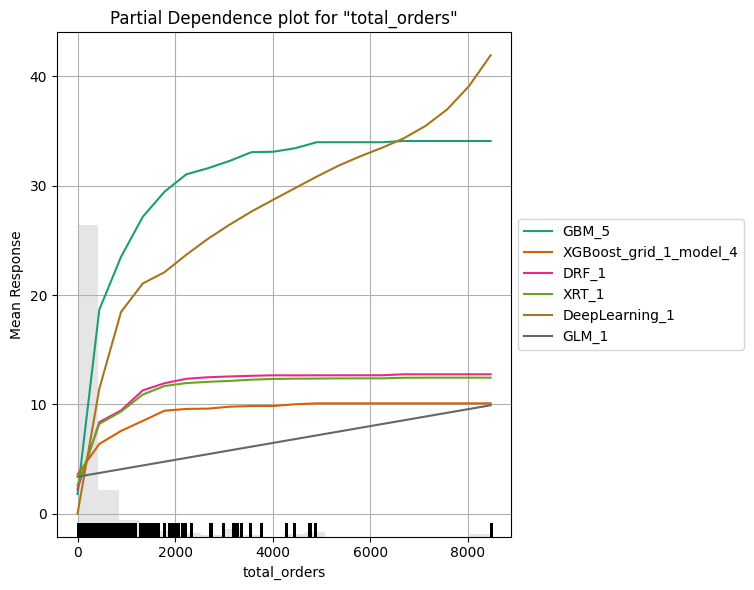

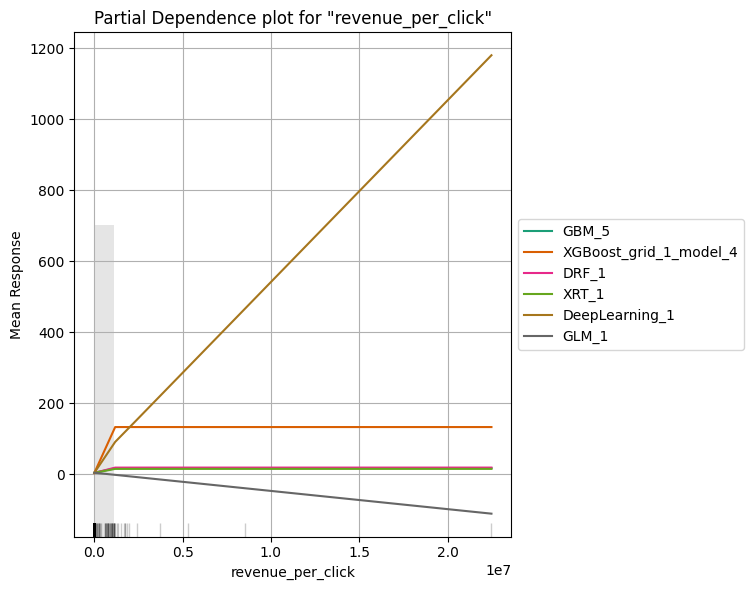

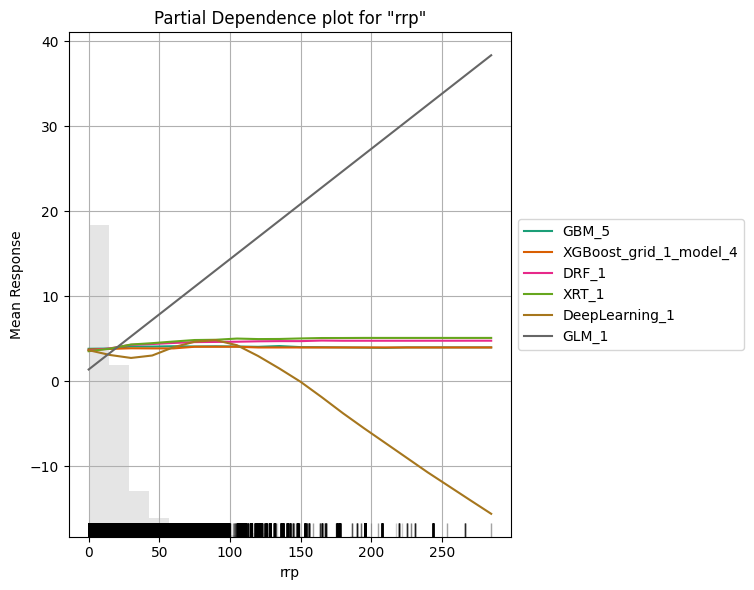

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

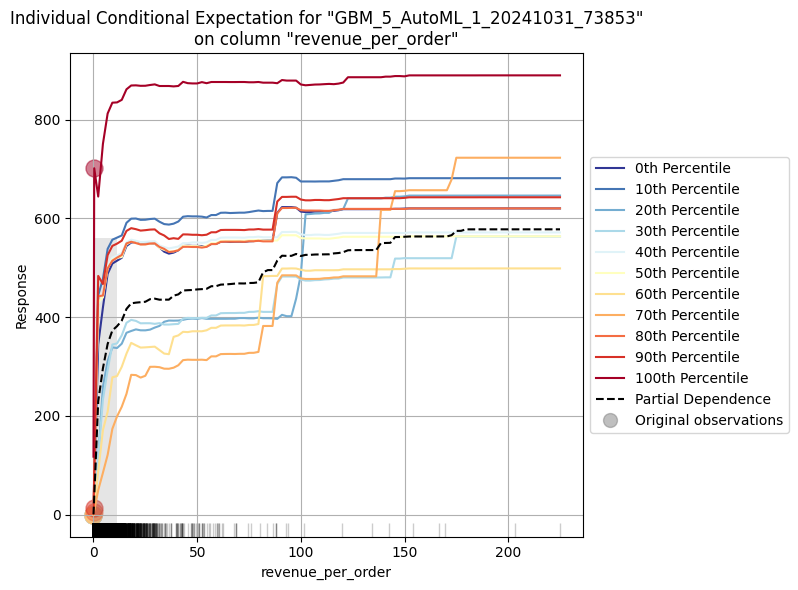

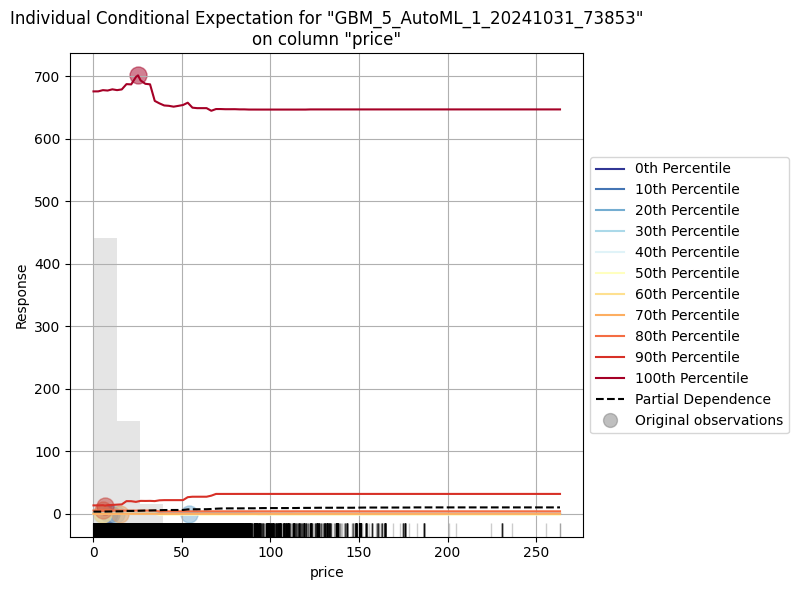

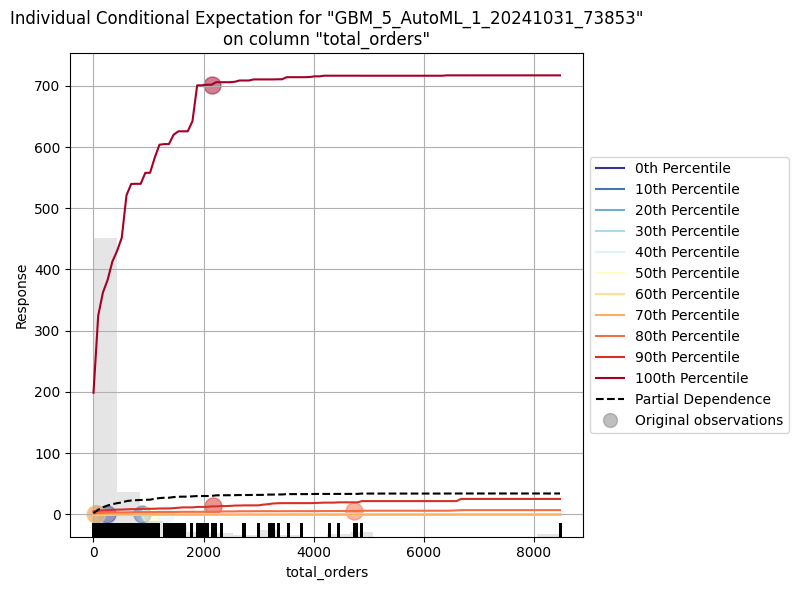

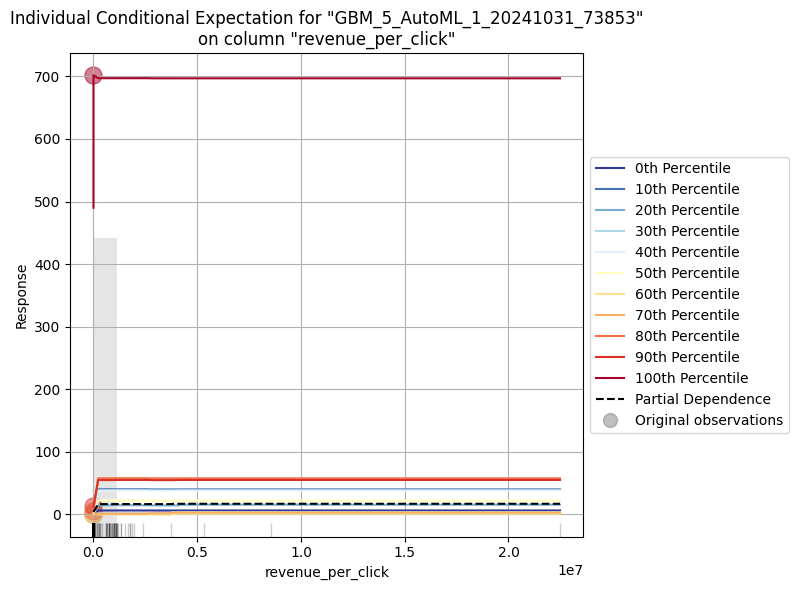

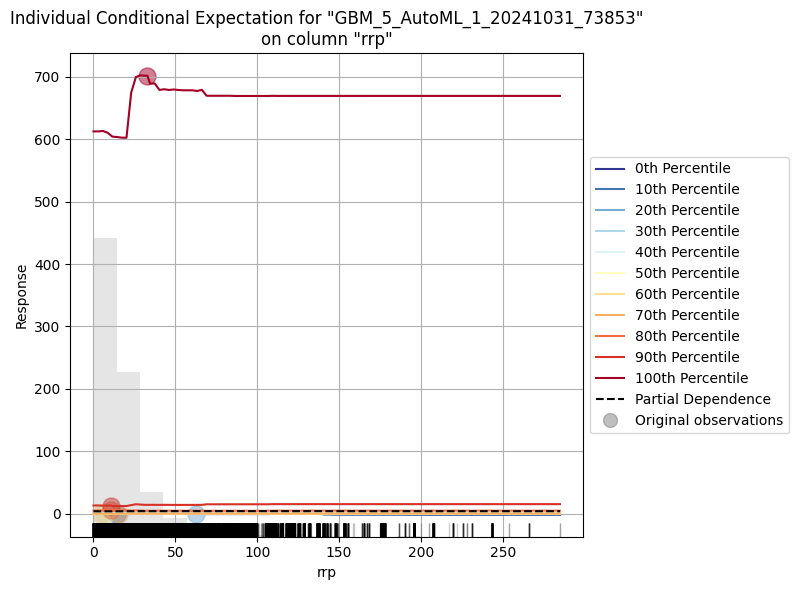

<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Run your explain model function with figsize specified
explain_plot = AutoML.explain(frame=test, figsize=(8, 6))

# Save the figure to Google Drive
plt.savefig('/content/drive/MyDrive/explain_plot.png', format='png', bbox_inches='tight')
